In [1]:
TSV_DIR = '../data/breseq/tsv_minus_references/'
TSV_DIR_J = '../data/breseq/tsv_minus_references_minus_shared/'
FREQ = 0.15

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('paper')

from matplotlib import rcParams, colors, cm
import matplotlib.patches as mpatches
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
import os
import gzip
import numpy as np
import pandas as pd
from Bio import SeqIO
from goatools.obo_parser import GODag
from goatools.goea.go_enrichment_ns import GOEnrichmentStudy

In [4]:
!wget -O ../data/go-basic.obo 'http://purl.obolibrary.org/obo/go/go-basic.obo'

--2024-12-10 15:42:12--  http://purl.obolibrary.org/obo/go/go-basic.obo
Resolving purl.obolibrary.org (purl.obolibrary.org)... 172.64.150.197, 104.18.37.59, 2606:4700:4400::6812:253b, ...
Connecting to purl.obolibrary.org (purl.obolibrary.org)|172.64.150.197|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://current.geneontology.org/ontology/go-basic.obo [following]
--2024-12-10 15:42:12--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontology.org)... 18.245.31.93, 18.245.31.87, 18.245.31.80, ...
Connecting to current.geneontology.org (current.geneontology.org)|18.245.31.93|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31203206 (30M) [text/obo]
Saving to: ‘../data/go-basic.obo’

../data/go-basic.ob 100%[===================>]  29.76M   101MB/s    in 0.3s    

2024-12-10 15:42:12 (101 MB/s) - ‘../data/go-basic.obo’ saved [31203206/31203206]



In [5]:
full_order = [
    'E. coli KFF-acpP',
    'E. coli (ΔsbmA) KFF-acpP',
    'E. coli D-KFF-acpP',
    'E. coli (UPEC) KFF-acpP',

    'E. coli KFF-rpsH',

    'K. pneumoniae KFF-acpP',
    'S. enterica KFF-acpP',

    'E. coli RXR-acpP',
    'P. aeruginosa RXR-acpP',
]

aso_order = ['KFF-rpsH', 'KFF-acpP',
             'D-KFF-acpP', 'RXR-acpP']

hue_order = ['E. coli', 'E. coli (ΔsbmA)',
             'E. coli (UPEC)',
             'K. pneumoniae',
             'S. enterica',
             'P. aeruginosa']

tab20 = sns.color_palette('tab20')
tab20c = sns.color_palette('tab20c')

palette = {'E. coli': tab20c[0],
           'E. coli (ΔsbmA)': tab20[6],
           'E. coli (UPEC)': tab20c[12],
           'K. pneumoniae': tab20c[4],
           'S. enterica': tab20c[8],
           'P. aeruginosa': tab20[12]}

In [6]:
tags = {'M': ('KFF-acpP', 'E. coli'),
        'J': ('KFF-acpP', 'E. coli (ΔsbmA)'),
        'A': ('D-KFF-acpP', 'E. coli'),
        'S': ('KFF-acpP', 'S. enterica'),
        'R': ('KFF-rpsH', 'E. coli'),
        'K': ('KFF-acpP', 'K. pneumoniae'),
        'U': ('KFF-acpP', 'E. coli (UPEC)'),
        'X': ('RXR-acpP', 'E. coli'),
        'P': ('RXR-acpP', 'P. aeruginosa')}

In [7]:
dsbma = {'E. coli': (.396639, .397859),
         'E. coli (ΔsbmA)': (.396639, .397859),
         'E. coli (UPEC)': (.464110, .465330),
         'K. pneumoniae': (2.935730, 2.936950),
         'S. enterica': (.429845, .431065)}

In [8]:
dacpp = {'E. coli': (1.151615, 1.151851),
         'E. coli (ΔsbmA)': (1.151615, 1.151851),
         'E. coli (UPEC)': (1.142494, 1.142730),
         'K. pneumoniae': (2.044808, 2.045044),
         'S. enterica': (1.236255, 1.236491),
         'P. aeruginosa': (3.324947, 3.325183)}

In [9]:
drpsh = {'E. coli': (1.151615, 1.151851)}

In [10]:
l2name = {}
for tag, fname in zip(['E. coli', 'E. coli (ΔsbmA)',
                       'E. coli (UPEC)', 'K. pneumoniae',
                       'P. aeruginosa', 'S. enterica'],
                      ['ecoli.tsv', 'ecoli.tsv',
                       'upec.tsv', 'klebsiella.tsv',
                       'pseudomonas.tsv', 'salmonella.tsv']):
    l2name[tag] = pd.read_csv(f'../data/references/tsv/{fname}',
                              sep='\t', header=None,
                              index_col=3)[4].to_dict()

In [11]:
obodag = GODag('../data/go-basic.obo')

../data/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms


In [12]:
cogs = {}
gos = {}
gol = {}
pname = {}
goe = {}
for tag, fname in zip(['E. coli', 'E. coli (ΔsbmA)',
                       'E. coli (UPEC)', 'K. pneumoniae',
                       'P. aeruginosa', 'S. enterica'],
                      ['ecoli.emapper.annotations', 'ecoli.emapper.annotations',
                       'upec.emapper.annotations', 'klebsiella.emapper.annotations',
                       'pseudomonas.emapper.annotations', 'salmonella.emapper.annotations']):
    e = pd.read_csv(f'../data/references/emapper/{fname}.gz',
                    sep='\t', skiprows=4,
                    skipfooter=3, index_col=0, engine='python')
    cogs[tag] = {x[0]: {y.split('@')[0]
                        for y in x[1].values[0].split(',')
                        if y.endswith('@2|Bacteria')}
                 for x in e[['eggNOG_OGs']].iterrows()}
    gos[tag] = {y for x in e['GOs'].values
                  if str(x) != 'nan'
                  for y in x.split(',')}
    gol[tag] = {x[0]: set(x[1].values[0].split(','))
                      if str(x[1].values[0]) != 'nan'
                      else set()
                for x in e[['GOs']].iterrows()}
    pname[tag] = {x[0]: x[1].values[0]
                  for x in e[['Preferred_name']].iterrows()}
    goe[tag] = GOEnrichmentStudy(gol[tag].keys(), gol[tag],
                                 obodag, methods=['fdr_bh'])

for tag in pname:
    for k, v in pname[tag].items():
        if v == '-':
            pname[tag][k] = k


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  4,073 of  4,073 population items found in association


409 GO IDs NOT FOUND IN ASSOCIATION: GO:0008689 GO:0008272 GO:0019439 GO:1905114 GO:0052116 GO:0070035 GO:0072581 GO:0052596 GO:0034471 GO:0102480 GO:0008905 GO:0000453 GO:0034419 GO:0005844 GO:0009108 GO:0000726 GO:0009405 GO:0009991 GO:0045260 GO:0018913 GO:0120038 GO:0071702 GO:0070084 GO:0009109 GO:0072502 GO:0102040 GO:1901564 GO:0097056 GO:0070470 GO:0044249 GO:0045226 GO:0010941 GO:0061732 GO:0052060 GO:0016290 GO:0032504 GO:0044247 GO:0044262 GO:0046145 GO:0006069 GO:0052565 GO:0055069 GO:0098713 GO:0052857 GO:0042136 GO:0052589 GO:0018307 GO:0000990 GO:0018065 GO:2001020 GO:0097223 GO:0051187 GO:0044110 GO:0044237 GO:0052590 GO:0052740 GO:0045181 GO:0036405 GO:0044445 GO:0044424 GO:0032775 GO:0006876 GO:0051065 GO:0044255 GO:0006875 GO:0052195 GO:0071241 GO:0044275 GO:0034661 GO:0006490 GO:0030580 GO:0102500 GO:0006557 GO:0051272 GO:0102131 GO:0102742 GO:2000112 GO:0043621 GO:0006305 GO:0060548 GO:0009020 GO:1905267 GO:0046566 GO:0008819 GO:0044216 GO:0016458 GO:0072506 GO:004


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  4,073 of  4,073 population items found in association


409 GO IDs NOT FOUND IN ASSOCIATION: GO:0008689 GO:0008272 GO:0019439 GO:1905114 GO:0052116 GO:0070035 GO:0072581 GO:0052596 GO:0034471 GO:0102480 GO:0008905 GO:0000453 GO:0034419 GO:0005844 GO:0009108 GO:0000726 GO:0009405 GO:0009991 GO:0045260 GO:0018913 GO:0120038 GO:0071702 GO:0070084 GO:0009109 GO:0072502 GO:0102040 GO:1901564 GO:0097056 GO:0070470 GO:0044249 GO:0045226 GO:0010941 GO:0061732 GO:0052060 GO:0016290 GO:0032504 GO:0044247 GO:0044262 GO:0046145 GO:0006069 GO:0052565 GO:0055069 GO:0098713 GO:0052857 GO:0042136 GO:0052589 GO:0018307 GO:0000990 GO:0018065 GO:2001020 GO:0097223 GO:0051187 GO:0044110 GO:0044237 GO:0052590 GO:0052740 GO:0045181 GO:0036405 GO:0044445 GO:0044424 GO:0032775 GO:0006876 GO:0051065 GO:0044255 GO:0006875 GO:0052195 GO:0071241 GO:0044275 GO:0034661 GO:0006490 GO:0030580 GO:0102500 GO:0006557 GO:0051272 GO:0102131 GO:0102742 GO:2000112 GO:0043621 GO:0006305 GO:0060548 GO:0009020 GO:1905267 GO:0046566 GO:0008819 GO:0044216 GO:0016458 GO:0072506 GO:004


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  4,247 of  4,247 population items found in association


403 GO IDs NOT FOUND IN ASSOCIATION: GO:0008689 GO:0008272 GO:0019439 GO:1905114 GO:0052116 GO:0070035 GO:0072581 GO:0034471 GO:0102480 GO:0008905 GO:0000453 GO:0034419 GO:0005844 GO:0009108 GO:0000726 GO:0009405 GO:0009991 GO:0045260 GO:0018913 GO:0120038 GO:0071702 GO:0070084 GO:0009109 GO:0072502 GO:0102040 GO:1901564 GO:0097056 GO:0070470 GO:0044249 GO:0045226 GO:0010941 GO:0061732 GO:0052060 GO:0016290 GO:0032504 GO:0044247 GO:0044262 GO:0046145 GO:0006069 GO:0052565 GO:0055069 GO:0098713 GO:0052857 GO:0042136 GO:0052589 GO:0018307 GO:0000990 GO:0018065 GO:2001020 GO:0097223 GO:0051187 GO:0044110 GO:0044237 GO:0052590 GO:0052740 GO:0045181 GO:0036405 GO:0044445 GO:0044424 GO:0032775 GO:0006876 GO:0051065 GO:0044255 GO:0006875 GO:0052195 GO:0071241 GO:0044275 GO:0034661 GO:0006490 GO:0030580 GO:0102500 GO:0006557 GO:0051272 GO:0102131 GO:0102742 GO:2000112 GO:0043621 GO:0006305 GO:0060548 GO:0009020 GO:1905267 GO:0046566 GO:0008819 GO:0044216 GO:0016458 GO:0072506 GO:0044462 GO:000


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  4,758 of  4,758 population items found in association


379 GO IDs NOT FOUND IN ASSOCIATION: GO:0008689 GO:0008272 GO:0019439 GO:0070035 GO:0072581 GO:0052596 GO:0034471 GO:0000453 GO:0034419 GO:0005844 GO:0009108 GO:0000726 GO:0009405 GO:0009991 GO:0045260 GO:0018913 GO:0071702 GO:0070084 GO:0009109 GO:0072502 GO:0102040 GO:1901564 GO:0097056 GO:0070470 GO:0044249 GO:0045226 GO:0010941 GO:0061732 GO:0052060 GO:0016290 GO:0032504 GO:0044247 GO:0044262 GO:0046145 GO:0052565 GO:0055069 GO:0098713 GO:0052857 GO:0042136 GO:0052589 GO:0018307 GO:0000990 GO:0018065 GO:2001020 GO:0097223 GO:0051187 GO:0044110 GO:0044237 GO:0052590 GO:0052740 GO:0045181 GO:0036405 GO:0044445 GO:0044424 GO:0032775 GO:0006876 GO:0051065 GO:0044255 GO:0006875 GO:0071241 GO:0044275 GO:0034661 GO:0006490 GO:0030580 GO:0102500 GO:0006557 GO:0051272 GO:0102131 GO:0102742 GO:2000112 GO:0043621 GO:0006305 GO:0060548 GO:0009020 GO:1905267 GO:0046566 GO:0008819 GO:0044216 GO:0016458 GO:0072506 GO:0044462 GO:0006732 GO:0102955 GO:0042895 GO:0010528 GO:0019313 GO:0031975 GO:000


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  5,477 of  5,477 population items found in association


343 GO IDs NOT FOUND IN ASSOCIATION: GO:0008689 GO:0008272 GO:0019439 GO:0052116 GO:0070035 GO:0034471 GO:0102480 GO:0008905 GO:0000453 GO:0005844 GO:0009108 GO:0000726 GO:0009405 GO:0009991 GO:0045260 GO:0018913 GO:0071702 GO:0070084 GO:0009109 GO:0072502 GO:0102040 GO:1901564 GO:0097056 GO:0070470 GO:0044249 GO:0045226 GO:0006471 GO:0010941 GO:0061732 GO:0052060 GO:0016290 GO:0032504 GO:0044247 GO:0044262 GO:0046145 GO:0052565 GO:0055069 GO:0044439 GO:0098713 GO:0052857 GO:0042136 GO:0052589 GO:0018307 GO:0000990 GO:0018065 GO:2001020 GO:0097223 GO:0051187 GO:0044110 GO:0044237 GO:0052590 GO:0045181 GO:0044445 GO:0044424 GO:0032775 GO:0006876 GO:0051065 GO:0044255 GO:0006875 GO:0052195 GO:0071241 GO:0044275 GO:0034661 GO:0006490 GO:0030580 GO:0102500 GO:0006557 GO:0102131 GO:2000112 GO:0043621 GO:0006305 GO:0060548 GO:1905267 GO:0008819 GO:0044216 GO:0016458 GO:0004085 GO:0072506 GO:0044462 GO:0006732 GO:0102955 GO:0042895 GO:0010528 GO:0045264 GO:0031975 GO:0006165 GO:0051271 GO:190


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  4,542 of  4,542 population items found in association


400 GO IDs NOT FOUND IN ASSOCIATION: GO:0008689 GO:0008272 GO:0019439 GO:1905114 GO:0052116 GO:0070035 GO:0072581 GO:0034471 GO:0102480 GO:0008905 GO:0000453 GO:0034419 GO:0005844 GO:0009108 GO:0000726 GO:0009405 GO:0009991 GO:0045260 GO:0018913 GO:0120038 GO:0071702 GO:0070084 GO:0009109 GO:0072502 GO:0102040 GO:1901564 GO:0097056 GO:0070470 GO:0044249 GO:0045226 GO:0010941 GO:0061732 GO:0052060 GO:0016290 GO:0032504 GO:0044247 GO:0044262 GO:0046145 GO:0052565 GO:0055069 GO:0098713 GO:0052857 GO:0042136 GO:0018307 GO:0000990 GO:0018065 GO:2001020 GO:0097223 GO:0051187 GO:0044110 GO:0044237 GO:0052590 GO:0052740 GO:0045181 GO:0036405 GO:0044445 GO:0044424 GO:0032775 GO:0006876 GO:0051065 GO:0044255 GO:0006875 GO:0052195 GO:0071241 GO:0044275 GO:0034661 GO:0006490 GO:0030580 GO:0102500 GO:0006557 GO:0051272 GO:0102131 GO:2000112 GO:0043621 GO:0006305 GO:0060548 GO:0009020 GO:1905267 GO:0046566 GO:0008819 GO:0044216 GO:0016458 GO:0072506 GO:0044462 GO:0006732 GO:0102955 GO:0042895 GO:001

In [13]:
refs = {}
glen = {}
pseudos = {}
for name, fname in zip(['E. coli',
                        'E. coli (ΔsbmA)',
                        'E. coli (UPEC)',
                        'S. enterica', 'K. pneumoniae',
                        'P. aeruginosa'],
                       ['ecoli.gbk.gz',
                        'ecoli.gbk.gz',
                        'upec.gbk.gz',
                        'salmonella.gbk.gz',
                        'klebsiella.gbk.gz',
                        'pseudomonas.gbk.gz']):
    gpos = {}
    pseudos[name] = set()
    i = 0
    for s in SeqIO.parse(gzip.open(f'../data/references/gbk/{fname}',
                                   'rt'), 'genbank'):
        for f in s.features:
            if 'locus_tag' not in f.qualifiers:
                continue
            l = f.qualifiers['locus_tag'][0]
            if 'pseudo' in f.qualifiers:
                pseudos[name].add(l)
            gpos[l] = ((int(f.location.start) + int(f.location.end)) // 2) + i
        i += len(s)
    glen[name] = i
    refs[name] = gpos

In [14]:
# here we parse the results
# and generate the final table
res = []
for f in os.listdir(TSV_DIR):
    if not f.endswith('.tsv'):
        continue
    fset = '.'.join(f.split('.')[:-1])[0]
    if fset == 'J':
        m = pd.read_csv(f'{TSV_DIR_J}/{f}', sep='\t')
    else:
        m = pd.read_csv(f'{TSV_DIR}/{f}', sep='\t')
    m = m[m['frequency'] >= FREQ].copy()
    m['locus_bed'] = [np.nan if str(x) == '.'
                      else x
                      for x in m['locus_bed'].values]
    m['name_bed'] = [np.nan if str(x) == '.'
                      else x
                      for x in m['name_bed'].values]
    m['set'] = '.'.join(f.split('.')[:-1])[0]
    m['sample'] = '.'.join(f.split('.')[:-1])
    m['aso'] = tags['.'.join(f.split('.')[:-1])[0]][0]
    m['species'] = tags['.'.join(f.split('.')[:-1])[0]][1]
    res.append(m)
m = pd.concat(res)

In [15]:
m['species'].unique()

array(['K. pneumoniae', 'E. coli (UPEC)', 'E. coli', 'P. aeruginosa',
       'S. enterica', 'E. coli (ΔsbmA)'], dtype=object)

In [16]:
m['locus'] = [y if str(x) == 'nan' and str(y) != 'nan'
              else x
              for x, y in m[['locus_bed', 'locus_tags_promoter']].values]
names = []
for x, y, z in m[['name_bed', 'genes_promoter', 'locus']].values:
    if str(x) != 'nan':
        names.append(x)
    elif str(x) == 'nan' and str(y) != 'nan':
        names.append(y)
    else:
        names.append(z)
m['locus_pos'] = [refs[species].get(x, (p1 + p2) // 2)
                  for p1, p2, species, x in m[['position_start',
                                               'position_end',
                                               'species', 'locus']].values]
m['name'] = names
m['og'] = [pname[tag].get(x, x)
           for tag, x in m[['species', 'locus']].values]
m['pseudogene'] = [True if x in pseudos[y]
                   else False
                   for x, y in m[['locus', 'species']].values]
m = m.reset_index(drop=True)

In [17]:
m.columns

Index(['chrom', 'position_start', 'position_end', 'mutation_category',
       'aa_new_seq', 'aa_position', 'aa_ref_seq', 'codon_new_seq',
       'codon_number', 'codon_position', 'codon_ref_seq', 'freq', 'frequency',
       'gene_name', 'gene_position', 'gene_product', 'gene_strand',
       'genes_inactivated', 'genes_overlapping', 'genes_promoter',
       'insert_position', 'locus_tag', 'locus_tags_inactivated',
       'locus_tags_overlapping', 'locus_tags_promoter', 'mtype', 'pos',
       'ref_seq', 'sample', 'snp_type', 'transl_table', 'chrom_bed',
       'start_bed', 'end_bed', 'locus_bed', 'name_bed', 'set', 'aso',
       'species', 'overlap', 'side_1_position', 'side_1_seq_id',
       'side_1_strand', 'side_2_position', 'side_2_seq_id', 'side_2_strand',
       'multiple_polymorphic_SNPs_in_same_codon', 'repeat_length',
       'repeat_new_copies', 'repeat_ref_copies', 'repeat_seq', 'repeat_size',
       'mediated', 'ins_end', 'locus', 'locus_pos', 'name', 'og',
       'pseudogene'

In [18]:
cols = ['set', 'aso', 'species',
        'sample',
        'chrom', 'position_start', 'position_end', 'mutation_category',
        'frequency',
        'locus', 'name', 'og', 'pseudogene',
        
        'aa_new_seq', 'aa_position', 'aa_ref_seq', 'codon_new_seq',
        'codon_number', 'codon_position', 'codon_ref_seq',
        'gene_name', 'gene_position', 'gene_product', 'gene_strand',
        'genes_inactivated', 'genes_overlapping', 'genes_promoter',
        'insert_position', 'locus_tag', 'locus_tags_inactivated',
        'locus_tags_overlapping', 'locus_tags_promoter',
        'ref_seq',
        'snp_type', 'transl_table',
        'repeat_size', 'mediated', 'repeat_length',
        'repeat_new_copies', 'repeat_ref_copies', 'repeat_seq', 'ins_end',]

In [19]:
m[cols].sort_values(['set', 'sample',
                     'chrom', 'position_start']).to_csv('all_mutations.tsv.gz',
                                                        sep='\t',
                                                        index=False)

In [20]:
# quickly check which orthologous group
# is most frequently mutated
m.groupby(['aso', 'species', 'og'])['sample'].nunique().sort_values()

aso         species          og         
RXR-acpP    P. aeruginosa    hisF            1
D-KFF-acpP  E. coli          b2352           1
RXR-acpP    P. aeruginosa    yut             1
                             kefB            1
                             yjiA            1
                                            ..
                             PA0723         10
KFF-acpP    E. coli (ΔsbmA)  b4586          10
            E. coli (UPEC)   ECP_RS20095    10
RXR-acpP    P. aeruginosa    mexT           10
                             ytnM           10
Name: sample, Length: 277, dtype: int64

In [21]:
m['mutation_category'].unique()

array(['small_indel', 'snp_nonsynonymous', 'snp_intergenic',
       'snp_synonymous', 'mobile_element_insertion_JC', 'snp_noncoding',
       'large_deletion', 'snp_nonsense', 'mobile_element_insertion',
       'snp_pseudogene', 'large_substitution'], dtype=object)

In [22]:
len(m['sample'].unique())

89

In [23]:
# here for plotting purposes
# I am assigning a number to each mutation type
t2i = {
    'snp_nonsynonymous': 0,
    
    'snp_nonsense': 1,
    
    'small_indel': 2,

    'snp_noncoding': 3,
    
    'snp_intergenic': 4,
    'snp_pseudogene': 4,
    
    'snp_synonymous': 5,
    
    'large_insertion': 6,
    'large_deletion': 6,
    'large_substitution': 6,
    
    'mobile_element_insertion': 7,

    'mobile_element_insertion_JC': 8,
}

In [24]:
# and here the corresponding colors
colors = [
# 0 snp_nonsynonymous
    'xkcd:pale red',
# 1 snp_nonsense
    'xkcd:bright red',
# 2 small_indel
    'xkcd:rust',
# 3 snp_noncoding
    'xkcd:aqua green',
# 4 snp_intergenic
    'xkcd:grey',
# 5 snp_synonymous
    'xkcd:steel',
# 6 large_deletion
    'xkcd:neon purple',
# 7 mobile_element_insertion
    'xkcd:violet',
# 8 mobile_element_insertion
    'xkcd:violet red',
]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
cmap.set_under('xkcd:light grey')

In [25]:
# adding the numerical encoding for each mutation type
m['ntype'] = [t2i.get(x, -1) for x in m['mutation_category'].values]

In [26]:
# small function to account for the fact that a single
# gene in a strain might have multiple mutations
# this function picks the right number for each gene
# based on a priority list:
# mutations with higher likelihood to be deleterious
# to the function of the gene are prioritized
def pick_mtype(v):
    values = v.values
    if 6 in values or 7 in values:
        return 7
    elif 8 in values:
        return 8
    elif 1 in values:
        return 1
    elif 0 in values:
        return 0
    elif 2 in values:
        return 2
    elif 3 in values:
        return 3
    elif 4 in values:
        return 4
    elif 5 in values:
        return 5
    elif -1 in values:
        return -1
    else:
        raise ValueError(f'missing case for {str(sorted(set(values)))}')

In [27]:
m[(~m['ntype'].isin([4, 5])) &
  (~m['pseudogene'])]['mutation_category'].unique()

array(['small_indel', 'snp_nonsynonymous', 'mobile_element_insertion_JC',
       'snp_noncoding', 'large_deletion', 'snp_nonsense',
       'mobile_element_insertion', 'large_substitution'], dtype=object)

In [28]:
res = []
cname = {}
# also filter out small indels in intergenic regions
nidx = [x for x, row in m[m['ntype'] == 2].iterrows()
        if 'intergenic' in str(row['gene_position'])]
t = m.loc[m.index.difference(nidx)]
#
for _, row in t[(~t['ntype'].isin([4, 5])) &
                (~t['pseudogene'])].iterrows():
    dset = row['set']
    tag = row['species']
    aso = row['aso']
    sample = row['sample']
    mtype = row['mutation_category']
    ntype = row['ntype']
    locus = row['locus']
    name = row['name']
    og = row['og']
    for cog in cogs[tag].get(locus, [locus]):
        cname[cog] = cname.get(cog, {})
        cname[cog][og] = cname[cog].get(og, 0)
        cname[cog][og] += 1
        res.append([dset, tag, aso, sample, mtype,
                    ntype, locus, name, og, cog])
cname = {k: sorted(v, key=lambda x: v[x])[-1]
         for k, v in cname.items()}
c = pd.DataFrame(res,
                 columns=['set', 'species', 'aso',
                          'sample', 'mutation_category',
                          'ntype', 'locus', 'name', 'og',
                          'cog'])
c = c.dropna()
c['dname'] = [cname[x] if x != cname[x]
              else x
              for x in c['cog'].values]
c['dname'] = [l2name[y].get(x, x) if l2name[y].get(x, x) != '.'
              else x
              for x, y in c[['dname', 'species']].values]

In [29]:
cbak = c.copy()

In [30]:
cbak[cbak['cog'] == 'COG3468']

,set,species,aso,sample,mutation_category,ntype,locus,name,og,cog,dname
7,U,E. coli (UPEC),KFF-acpP,U10,snp_nonsynonymous,0,ECP_RS07185,ECP_RS07185,ECP_RS07185,COG3468,ECP_RS07185
9,U,E. coli (UPEC),KFF-acpP,U10,snp_nonsynonymous,0,ECP_RS07185,ECP_RS07185,ECP_RS07185,COG3468,ECP_RS07185
135,U,E. coli (UPEC),KFF-acpP,U03,snp_nonsynonymous,0,ECP_RS07185,ECP_RS07185,ECP_RS07185,COG3468,ECP_RS07185
137,U,E. coli (UPEC),KFF-acpP,U03,snp_nonsynonymous,0,ECP_RS07185,ECP_RS07185,ECP_RS07185,COG3468,ECP_RS07185
305,U,E. coli (UPEC),KFF-acpP,U05,snp_nonsynonymous,0,ECP_RS07185,ECP_RS07185,ECP_RS07185,COG3468,ECP_RS07185
307,U,E. coli (UPEC),KFF-acpP,U05,snp_nonsynonymous,0,ECP_RS07185,ECP_RS07185,ECP_RS07185,COG3468,ECP_RS07185
341,U,E. coli (UPEC),KFF-acpP,U04,snp_nonsynonymous,0,ECP_RS07185,ECP_RS07185,ECP_RS07185,COG3468,ECP_RS07185
343,U,E. coli (UPEC),KFF-acpP,U04,snp_nonsynonymous,0,ECP_RS07185,ECP_RS07185,ECP_RS07185,COG3468,ECP_RS07185
357,U,E. coli (UPEC),KFF-acpP,U06,snp_nonsynonymous,0,ECP_RS07185,ECP_RS07185,ECP_RS07185,COG3468,ECP_RS07185
359,U,E. coli (UPEC),KFF-acpP,U06,snp_nonsynonymous,0,ECP_RS07185,ECP_RS07185,ECP_RS07185,COG3468,ECP_RS07185


In [31]:
c = c.groupby(['species', 'aso', 'dname'])['sample'].nunique().reset_index()

In [32]:
ch = c.pivot_table(index='dname', columns=['aso', 'species'],
                   values='sample', aggfunc='max',
                   fill_value=0)

In [33]:
ch = ch.loc[ch.T.sum().sort_values().index]

In [34]:
c = ch.unstack().reset_index()

In [35]:
c

,aso,species,dname,0
0,D-KFF-acpP,E. coli,IT767_RS02190,0
1,D-KFF-acpP,E. coli,PA0043,0
2,D-KFF-acpP,E. coli,IT767_RS02170,0
3,D-KFF-acpP,E. coli,PA4066,0
4,D-KFF-acpP,E. coli,PA3850,0
...,...,...,...,...
1435,RXR-acpP,P. aeruginosa,rpoS,2
1436,RXR-acpP,P. aeruginosa,mexT,10
1437,RXR-acpP,P. aeruginosa,fimE,0
1438,RXR-acpP,P. aeruginosa,ykfM,0


In [36]:
cc = c.groupby(['dname', 'aso'])[0].max().sort_values().reset_index()

In [37]:
m.groupby(['set', 'species', 'aso'])['sample'].nunique()

set  species          aso       
A    E. coli          D-KFF-acpP     9
J    E. coli (ΔsbmA)  KFF-acpP      10
K    K. pneumoniae    KFF-acpP      10
M    E. coli          KFF-acpP      10
P    P. aeruginosa    RXR-acpP      10
R    E. coli          KFF-rpsH      10
S    S. enterica      KFF-acpP      10
U    E. coli (UPEC)   KFF-acpP      10
X    E. coli          RXR-acpP      10
Name: sample, dtype: int64

In [38]:
aso_order

['KFF-rpsH', 'KFF-acpP', 'D-KFF-acpP', 'RXR-acpP']

/home/marco/miniconda3/envs/2024_aso_evolution/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


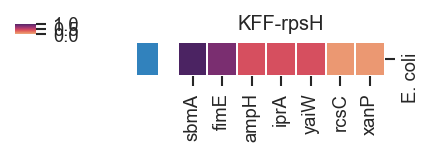

In [39]:
t = c[(c['aso'] == 'KFF-rpsH') &
      (c['dname'].isin(cc[(cc['aso'] == 'KFF-rpsH') &
                          (cc[0] > 0)]['dname'].values))].copy()
t[0] = t[0] / 10
tt = t.pivot_table(index='species',
              columns='dname', values=0)

tt = tt[tt.mean().sort_values(ascending=False).index]

cmap = plt.get_cmap('flare').copy()
cmap.set_under('xkcd:light grey')
cm = sns.clustermap(tt.loc[hue_order[0:1]],
               cmap=cmap,
               vmin=1E-100 / 10, vmax=1,
               row_cluster=False,
               col_cluster=False,
               figsize=(.4 * tt.loc[hue_order[0:1]].shape[1], .4 * tt.loc[hue_order[0:1]].shape[0]),
               xticklabels=True,
               yticklabels=True,
               linewidths=0.1,
               row_colors=[palette[x] for x in hue_order[0:1]],
               colors_ratio=0.08)

cm.ax_heatmap.set_title('KFF-rpsH')
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_ylabel('')

plt.savefig('KFF-rpsH_frequency_hm.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('KFF-rpsH_frequency_hm.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

/home/marco/miniconda3/envs/2024_aso_evolution/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


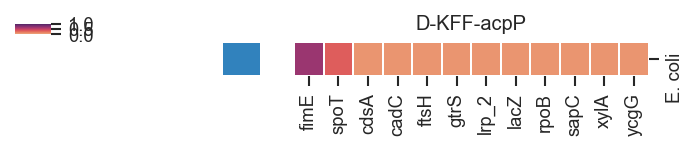

In [40]:
t = c[(c['aso'] == 'D-KFF-acpP') &
      (c['dname'].isin(cc[(cc['aso'] == 'D-KFF-acpP') &
                          (cc[0] > 0)]['dname'].values))].copy()
t[0] = t[0] / 9
tt = t.pivot_table(index='species',
              columns='dname', values=0)

tt = tt[tt.mean().sort_values(ascending=False).index]

cmap = plt.get_cmap('flare').copy()
cmap.set_under('xkcd:light grey')
cm = sns.clustermap(tt.loc[hue_order[0:1]],
               cmap=cmap,
               vmin=1E-100 / 10, vmax=1,
               row_cluster=False,
               col_cluster=False,
               figsize=(.4 * tt.loc[hue_order[0:1]].shape[1], .4 * tt.loc[hue_order[0:1]].shape[0]),
               xticklabels=True,
               yticklabels=True,
               linewidths=0.1,
               row_colors=[palette[x] for x in hue_order[0:1]],
               colors_ratio=0.08)

cm.ax_heatmap.set_title('D-KFF-acpP')
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_ylabel('')

plt.savefig('D-KFF-acpP_frequency_hm.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('D-KFF-acpP_frequency_hm.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

/home/marco/miniconda3/envs/2024_aso_evolution/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


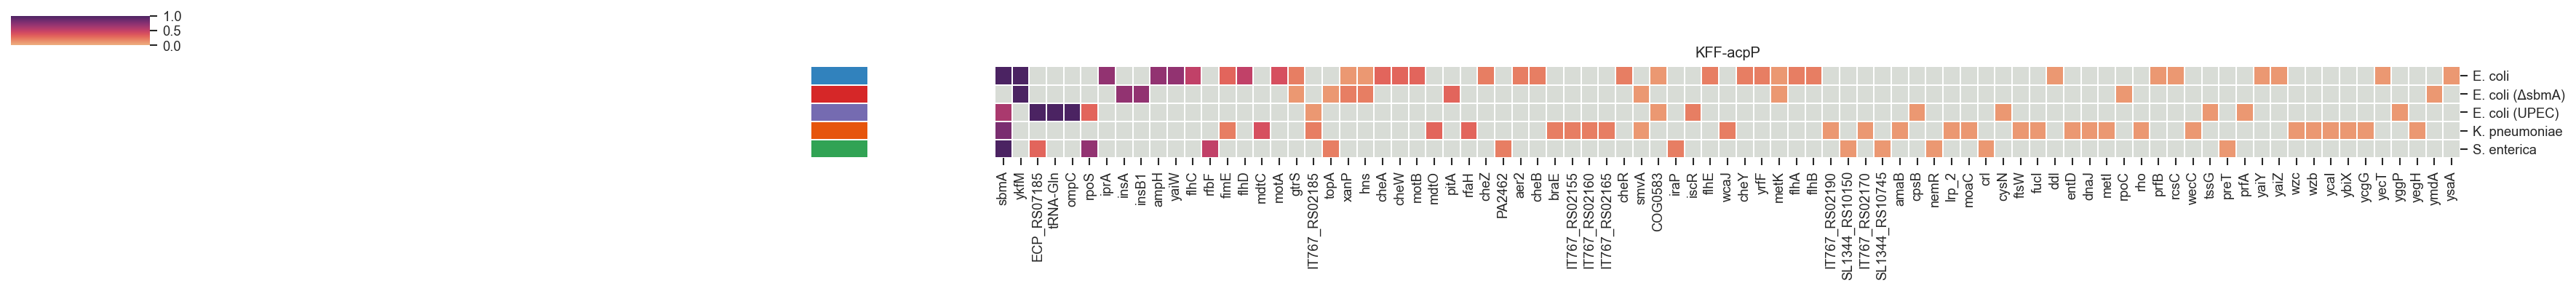

In [41]:
t = c[(c['aso'] == 'KFF-acpP') &
      (c['dname'].isin(cc[(cc['aso'] == 'KFF-acpP') &
                          (cc[0] > 0)]['dname'].values))].copy()
t[0] = t[0] / 10
tt = t.pivot_table(index='species',
              columns='dname', values=0)

tt = tt[tt.mean().sort_values(ascending=False).index]

tt = tt.rename(columns={'16S ribosomal RNA': '16S rRNA',
                        'mexT': 'COG0583'})

cmap = plt.get_cmap('flare').copy()
cmap.set_under('xkcd:light grey')
cm = sns.clustermap(tt.loc[hue_order[:-1]],
               cmap=cmap,
               vmin=1E-100 / 10, vmax=1,
               row_cluster=False,
               col_cluster=False,
               figsize=(.3 * tt.loc[hue_order[:-1]].shape[1], .3 * tt.loc[hue_order[:-1]].shape[0]),
               xticklabels=True,
               yticklabels=True,
               linewidths=0.1,
               row_colors=[palette[x] for x in hue_order[:-1]],
               # colors_ratio=0.05
                   )

cm.ax_heatmap.set_title('KFF-acpP')
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_ylabel('')

plt.savefig('KFF-acpP_frequency_hm_all.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('KFF-acpP_frequency_hm_all.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

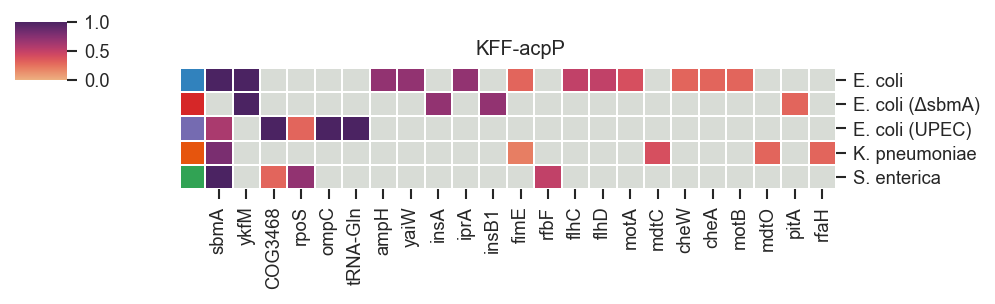

In [42]:
t = c[(c['aso'] == 'KFF-acpP') &
      (c['dname'].isin(cc[(cc['aso'] == 'KFF-acpP') &
                          (cc[0] > 2)]['dname'].values))].copy()
t[0] = t[0] / 10
tt = t.pivot_table(index='species',
              columns='dname', values=0)

tt = tt[tt.mean().sort_values(ascending=False).index]

tt = tt.rename(columns={'16S ribosomal RNA': '16S rRNA',
                        'mexT': 'COG0583',
                        'ECP_RS07185': 'COG3468',
                        'ECP_RS27130': 'hyp. protein',
                        'IT767_RS25830': 'COG4626'})

cmap = plt.get_cmap('flare').copy()
cmap.set_under('xkcd:light grey')
cm = sns.clustermap(tt.loc[hue_order[:-1]],
               cmap=cmap,
               vmin=1E-100 / 10, vmax=1,
               row_cluster=False,
               col_cluster=False,
               figsize=(.3 * tt.loc[hue_order[:-1]].shape[1], .43 * tt.loc[hue_order[:-1]].shape[0]),
               xticklabels=True,
               yticklabels=True,
               linewidths=0.1,
               row_colors=[palette[x] for x in hue_order[:-1]],
               # colors_ratio=0.05
                   )

cm.ax_heatmap.set_title('KFF-acpP')
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_ylabel('')

plt.savefig('KFF-acpP_frequency_hm.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('KFF-acpP_frequency_hm.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

/home/marco/miniconda3/envs/2024_aso_evolution/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


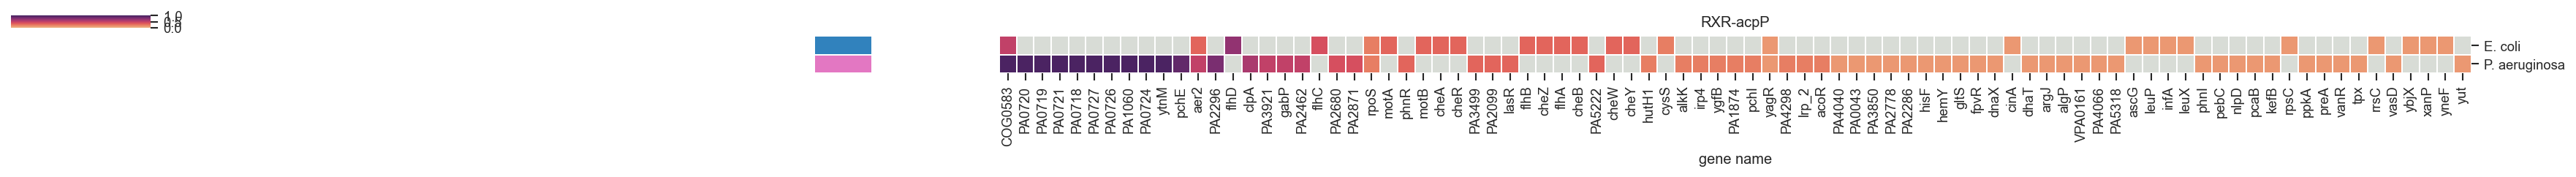

In [43]:
t = c[(c['aso'] == 'RXR-acpP') &
      (c['dname'].isin(cc[(cc['aso'] == 'RXR-acpP') &
                          (cc[0] > 0)]['dname'].values))].copy()
t[0] = t[0] / 10
tt = t.pivot_table(index='species',
              columns='dname', values=0)

tt = tt[tt.mean().sort_values(ascending=False).index]

tt = tt.rename(columns={'16S ribosomal RNA': '16S rRNA',
                        'mexT': 'COG0583'})

cmap = plt.get_cmap('flare').copy()
cmap.set_under('xkcd:light grey')
cm = sns.clustermap(tt.loc[[hue_order[0], hue_order[-1]]],
               cmap=cmap,
               vmin=1E-100 / 10, vmax=1,
               row_cluster=False,
               col_cluster=False,
               figsize=(.3 * tt.loc[[hue_order[0], hue_order[-1]]].shape[1],
                        .3 * tt.loc[[hue_order[0], hue_order[-1]]].shape[0]),
               xticklabels=True,
               yticklabels=True,
               linewidths=0.1,
               row_colors=[palette[x] for x in [hue_order[0], hue_order[-1]]],
               # colors_ratio=0.05
                   )

cm.ax_heatmap.set_title('RXR-acpP')
cm.ax_heatmap.set_xlabel('gene name')
cm.ax_heatmap.set_ylabel('')

plt.savefig('RXR-acpP_frequency_hm_all.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('RXR-acpP_frequency_hm_all.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

/home/marco/miniconda3/envs/2024_aso_evolution/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


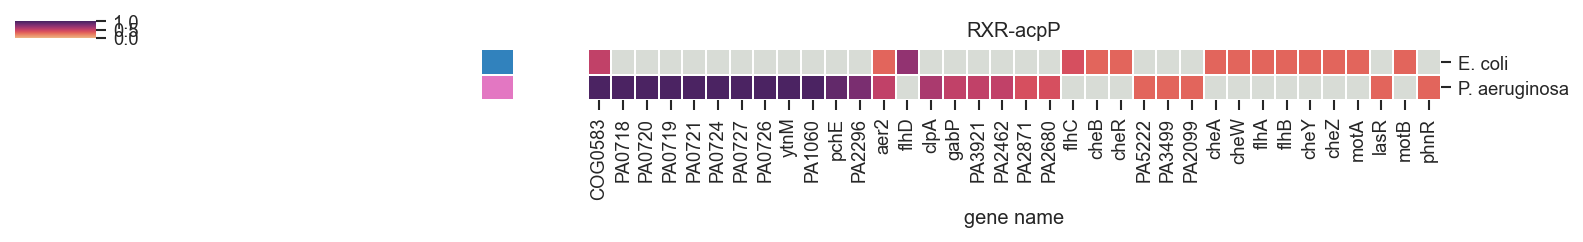

In [44]:
t = c[(c['aso'] == 'RXR-acpP') &
      (c['dname'].isin(cc[(cc['aso'] == 'RXR-acpP') &
                          (cc[0] > 2)]['dname'].values))].copy()
t[0] = t[0] / 10
tt = t.pivot_table(index='species',
              columns='dname', values=0)

tt = tt[tt.mean().sort_values(ascending=False).index]

tt = tt.rename(columns={'16S ribosomal RNA': '16S rRNA',
                        'mexT': 'COG0583'})

cmap = plt.get_cmap('flare').copy()
cmap.set_under('xkcd:light grey')
cm = sns.clustermap(tt.loc[[hue_order[0], hue_order[-1]]],
               cmap=cmap,
               vmin=1E-100 / 10, vmax=1,
               row_cluster=False,
               col_cluster=False,
               figsize=(.3 * tt.loc[[hue_order[0], hue_order[-1]]].shape[1],
                        .3 * tt.loc[[hue_order[0], hue_order[-1]]].shape[0]),
               xticklabels=True,
               yticklabels=True,
               linewidths=0.1,
               row_colors=[palette[x] for x in [hue_order[0], hue_order[-1]]],
               # colors_ratio=0.05
                   )

cm.ax_heatmap.set_title('RXR-acpP')
cm.ax_heatmap.set_xlabel('gene name')
cm.ax_heatmap.set_ylabel('')

plt.savefig('RXR-acpP_frequency_hm.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('RXR-acpP_frequency_hm.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

/tmp/ipykernel_2798261/1215541239.py:3: UserWarning: Adding colorbar to a different Figure <Figure size 1620x90 with 5 Axes> than <Figure size 45x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(cm.ax_heatmap.get_children()[0], orientation='vertical', cax=plt.gca())


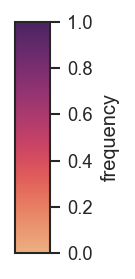

In [45]:
plt.figure(figsize=(0.3, 2))

plt.colorbar(cm.ax_heatmap.get_children()[0], orientation='vertical', cax=plt.gca())

plt.ylabel('frequency')

sns.despine(bottom=True,
            left=True,
            ax=plt.gca())

plt.savefig('frequency_cbar.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('frequency_cbar.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

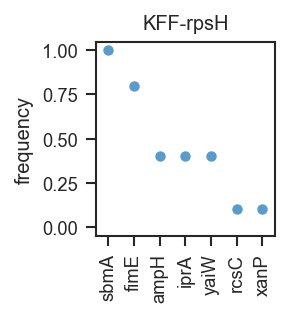

In [46]:
t = c[(c['aso'] == 'KFF-rpsH') &
      (c['dname'].isin(cc[(cc['aso'] == 'KFF-rpsH') &
                          (cc[0] > 0)]['dname'].values))].copy()
t[0] = t[0] / 10
sns.catplot(data=t,
            x='dname',
            y=0,
            height=2, aspect=1,
            alpha=0.8,
            hue_order=hue_order,
            palette=[palette[x] for x in hue_order],     
            hue='species',
            jitter=0.1,
            order=t.groupby('dname')[0].mean().sort_values(ascending=False).index,
            legend=False)
# plt.legend(facecolor='w', loc='upper right')
plt.xlabel('')
plt.ylabel('frequency')
plt.title('KFF-rpsH')
plt.xticks(rotation=90)
plt.ylim(-0.05, 1.05)
sns.despine(top=False, right=False)
plt.savefig('KFF-rpsH_frequency.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('KFF-rpsH_frequency.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

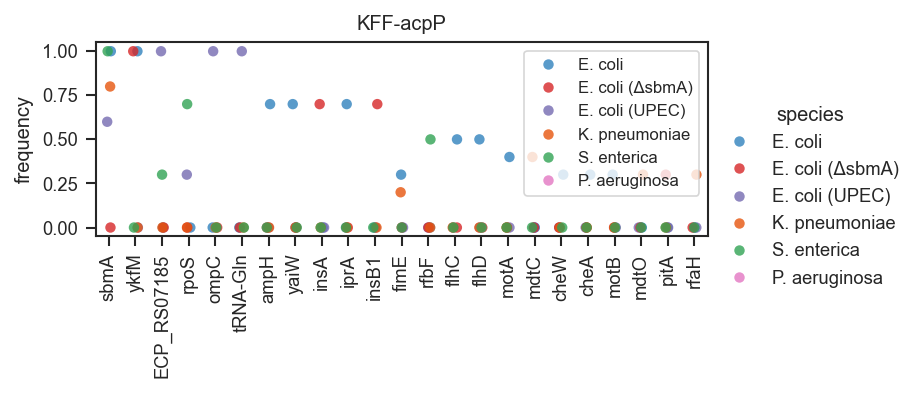

In [47]:
t = c[(c['aso'] == 'KFF-acpP') &
      (c['dname'].isin(cc[(cc['aso'] == 'KFF-acpP') &
                          (cc[0] > 2)]['dname'].values))].copy()
t[0] = t[0] / 10
sns.catplot(data=t,
            x='dname',
            y=0,
            height=2, aspect=2.5,
            alpha=0.8,
            hue_order=hue_order,
            palette=[palette[x] for x in hue_order],     
            hue='species',
            jitter=0.1,
            order=t.groupby('dname')[0].mean().sort_values(ascending=False).index)
plt.legend(facecolor='w', loc='upper right', fontsize=8)
plt.xlabel('')
plt.ylabel('frequency')
plt.title('KFF-acpP')
plt.xticks(rotation=90)
plt.ylim(-0.05, 1.05)
sns.despine(top=False, right=False)
plt.savefig('KFF-acpP_frequency.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('KFF-acpP_frequency.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

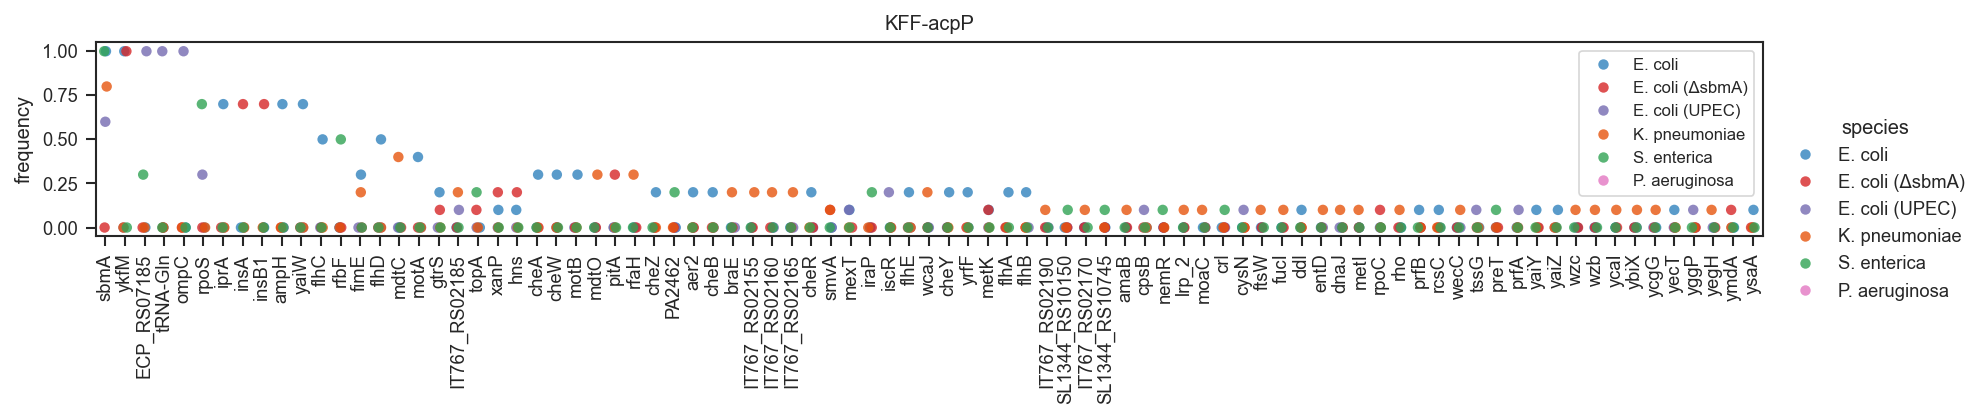

In [48]:
t = c[(c['aso'] == 'KFF-acpP') &
      (c['dname'].isin(cc[(cc['aso'] == 'KFF-acpP') &
                          (cc[0] > 0)]['dname'].values))].copy()
t[0] = t[0] / 10
sns.catplot(data=t,
            x='dname',
            y=0,
            height=2, aspect=6,
            alpha=0.8,
            hue_order=hue_order,
            palette=[palette[x] for x in hue_order],     
            hue='species',
            jitter=0.1,
            order=t.groupby('dname')[0].mean().sort_values(ascending=False).index)
plt.legend(facecolor='w', loc='upper right', fontsize=8)
plt.xlabel('')
plt.ylabel('frequency')
plt.title('KFF-acpP')
plt.xticks(rotation=90)
plt.ylim(-0.05, 1.05)
sns.despine(top=False, right=False)
plt.savefig('KFF-acpP_frequency_all.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('KFF-acpP_frequency_all.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

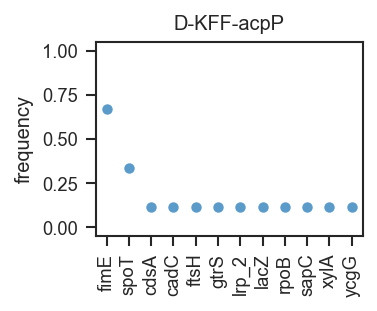

In [49]:
t = c[(c['aso'] == 'D-KFF-acpP') &
      (c['dname'].isin(cc[(cc['aso'] == 'D-KFF-acpP') &
                          (cc[0] > 0)]['dname'].values))].copy()
t[0] = t[0] / 9
sns.catplot(data=t,
            x='dname',
            y=0,
            height=2, aspect=1.3,
            alpha=0.8,
            hue_order=hue_order,
            palette=[palette[x] for x in hue_order],     
            hue='species',
            jitter=0.1,
            order=t.groupby('dname')[0].mean().sort_values(ascending=False).index,
            legend=False)
# plt.legend(facecolor='w', loc='upper right')
plt.xlabel('')
plt.ylabel('frequency')
plt.title('D-KFF-acpP')
plt.xticks(rotation=90)
plt.ylim(-0.05, 1.05)
sns.despine(top=False, right=False)
plt.savefig('D-KFF-acpP_frequency.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('D-KFF-acpP_frequency.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

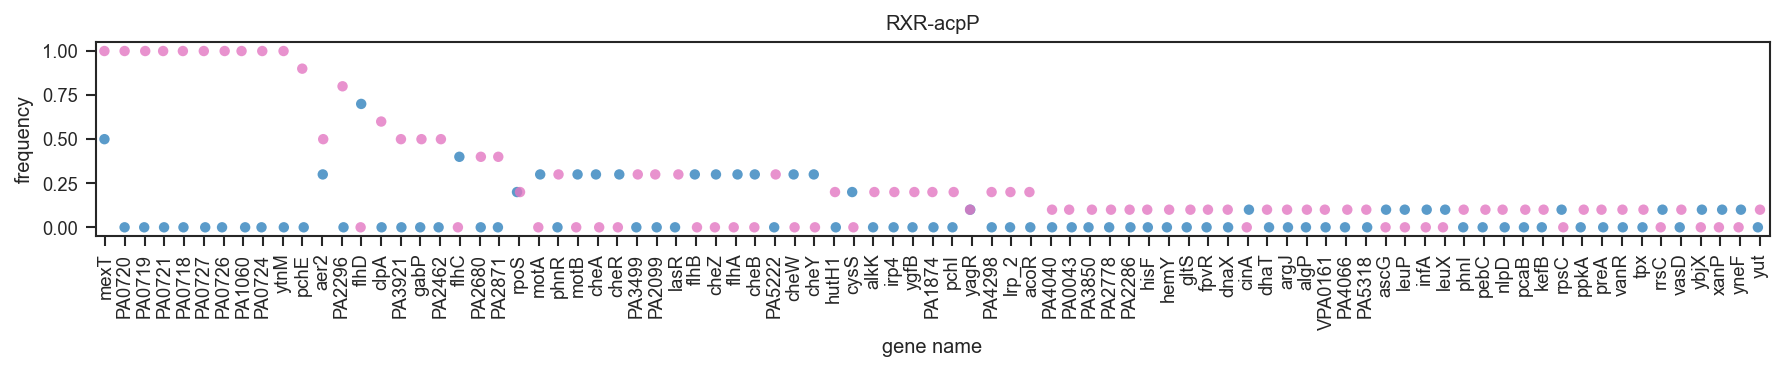

In [50]:
t = c[(c['aso'] == 'RXR-acpP') &
      (c['dname'].isin(cc[(cc['aso'] == 'RXR-acpP') &
                          (cc[0] > 0)]['dname'].values))].copy()
t[0] = t[0] / 10
sns.catplot(data=t,
            x='dname',
            y=0,
            height=2, aspect=6,
            alpha=0.8,
            hue_order=hue_order,
            palette=[palette[x] for x in hue_order],     
            hue='species',
            jitter=0.1,
            order=t.groupby('dname')[0].mean().sort_values(ascending=False).index,
            legend=False)
# plt.legend(facecolor='w', loc='upper right')
plt.xlabel('gene name')
plt.ylabel('frequency')
plt.title('RXR-acpP')
plt.xticks(rotation=90)
plt.ylim(-0.05, 1.05)
sns.despine(top=False, right=False)
plt.savefig('RXR-acpP_frequency_all.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('RXR-acpP_frequency_all.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

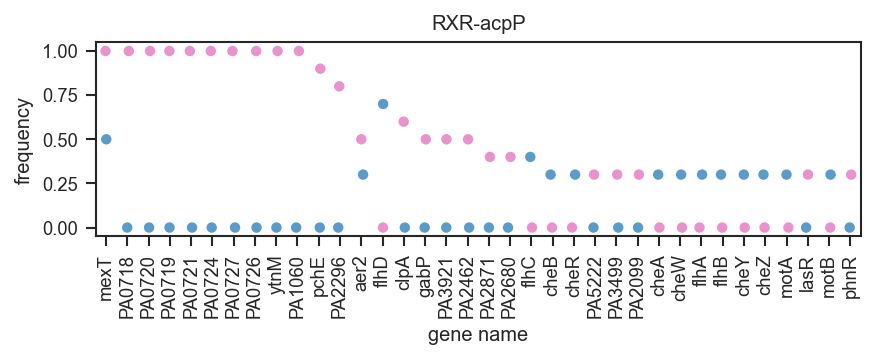

In [51]:
t = c[(c['aso'] == 'RXR-acpP') &
      (c['dname'].isin(cc[(cc['aso'] == 'RXR-acpP') &
                          (cc[0] > 2)]['dname'].values))].copy()
t[0] = t[0] / 10
sns.catplot(data=t,
            x='dname',
            y=0,
            height=2, aspect=3,
            alpha=0.8,
            hue_order=hue_order,
            palette=[palette[x] for x in hue_order],     
            hue='species',
            jitter=0.1,
            order=t.groupby('dname')[0].mean().sort_values(ascending=False).index,
            legend=False)
# plt.legend(facecolor='w', loc='upper right')
plt.xlabel('gene name')
plt.ylabel('frequency')
plt.title('RXR-acpP')
plt.xticks(rotation=90)
plt.ylim(-0.05, 1.05)
sns.despine(top=False, right=False)
plt.savefig('RXR-acpP_frequency.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('RXR-acpP_frequency.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [52]:
# also filter out small indels in intergenic regions
nidx = [x for x, row in m[m['ntype'] == 2].iterrows()
        if 'intergenic' in str(row['gene_position'])]
t = m.loc[m.index.difference(nidx)]
#

In [53]:
res = []
for tag in t['set'].unique():
    aso, species = tags[tag]

    tc = t[t['set'] == tag].groupby('locus')['sample'].nunique()
    tc[tc > 2].index
    
    result = goe[species].run_study(tc.index)
    
    passing = [x for x in result
               if x.get_pvalue() < 0.05]
    
    for go in passing:
        if go.depth < 3:
            continue
        go.study_items = [x for x in go.study_items]
        res.append([tag, species, aso] + [x.strip()
                                          for x in str(go).split('\t')])

if len(res) > 0:
    gor = pd.DataFrame(res,
                       columns=['set', 'species', 'aso'] + go.get_prtflds_default())


Runing  Ontology Analysis: current study set of 38 IDs.
100%     31 of     31 study items found in association
 82%     31 of     38 study items found in population(4758)
Calculating 5,483 uncorrected p-values using fisher_scipy_stats
   5,483 terms are associated with  3,092 of  4,758 population items
     443 terms are associated with     19 of     38 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing  Ontology Analysis: current study set of 21 IDs.
100%     15 of     15 study items found in association
 71%     15 of     21 study items found in population(4247)
Calculating 5,617 uncorrected p-values using fisher_scipy_stats
   5,617 terms are associated with  3,393 of  4,247 population items
     256 terms are associated with     10 of     21 study items
  METHOD f

In [54]:
gor

,set,species,aso,GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,M,E. coli,KFF-acpP,GO:0006935,BP,e,chemotaxis,10/39,25/4073,5.5e-15,3,10,1.6e-11,"b1881, b1882, b1883, b1884, b1885, b1886, b188..."
1,M,E. coli,KFF-acpP,GO:1901873,BP,e,regulation of post-translational protein modif...,3/39,3/4073,8.12e-07,8,3,0.000785,"b1886, b1887, b1888"
2,M,E. coli,KFF-acpP,GO:1901875,BP,e,positive regulation of post-translational prot...,3/39,3/4073,8.12e-07,9,3,0.000785,"b1886, b1887, b1888"
3,M,E. coli,KFF-acpP,GO:0050920,BP,e,regulation of chemotaxis,3/39,4/4073,3.23e-06,5,3,0.00208,"b1881, b1886, b1888"
4,M,E. coli,KFF-acpP,GO:0031401,BP,e,positive regulation of protein modification pr...,3/39,4/4073,3.23e-06,8,3,0.00208,"b1886, b1887, b1888"
5,M,E. coli,KFF-acpP,GO:0044781,BP,e,bacterial-type flagellum organization,5/39,28/4073,5.17e-06,5,5,0.003,"b1878, b1879, b1880, b1891, b1892"
6,M,E. coli,KFF-acpP,GO:0032101,BP,e,regulation of response to external stimulus,3/39,6/4073,1.59e-05,4,3,0.0084,"b1881, b1886, b1888"
7,M,E. coli,KFF-acpP,GO:0031399,BP,e,regulation of protein modification process,3/39,7/4073,2.77e-05,7,3,0.0134,"b1886, b1887, b1888"
8,M,E. coli,KFF-acpP,GO:0007165,BP,e,signal transduction,7/39,108/4073,5.79e-05,4,7,0.024,"b1882, b1883, b1885, b1886, b1887, b1888, b2218"
9,M,E. coli,KFF-acpP,GO:0023052,BP,e,signaling,7/39,115/4073,8.67e-05,3,7,0.0305,"b1882, b1883, b1885, b1886, b1887, b1888, b2218"


In [55]:
m.columns

Index(['chrom', 'position_start', 'position_end', 'mutation_category',
       'aa_new_seq', 'aa_position', 'aa_ref_seq', 'codon_new_seq',
       'codon_number', 'codon_position', 'codon_ref_seq', 'freq', 'frequency',
       'gene_name', 'gene_position', 'gene_product', 'gene_strand',
       'genes_inactivated', 'genes_overlapping', 'genes_promoter',
       'insert_position', 'locus_tag', 'locus_tags_inactivated',
       'locus_tags_overlapping', 'locus_tags_promoter', 'mtype', 'pos',
       'ref_seq', 'sample', 'snp_type', 'transl_table', 'chrom_bed',
       'start_bed', 'end_bed', 'locus_bed', 'name_bed', 'set', 'aso',
       'species', 'overlap', 'side_1_position', 'side_1_seq_id',
       'side_1_strand', 'side_2_position', 'side_2_seq_id', 'side_2_strand',
       'multiple_polymorphic_SNPs_in_same_codon', 'repeat_length',
       'repeat_new_copies', 'repeat_ref_copies', 'repeat_seq', 'repeat_size',
       'mediated', 'ins_end', 'locus', 'locus_pos', 'name', 'og', 'pseudogene',
     

In [56]:
# and here the corresponding colors
colors = [
# 0 snp_nonsynonymous
    'xkcd:pale red',
# 1 snp_nonsense
    'xkcd:bright red',
# 2 small_indel
    'xkcd:rust',
# 3 snp_noncoding
    'xkcd:aqua green',
# 4 snp_intergenic
    'xkcd:grey',
# 5 snp_synonymous
    'xkcd:steel',
# 6 large_deletion
    'xkcd:neon purple',
# 7 mobile_element_insertion
    'xkcd:violet',
# 8 mobile_element_insertion
    'xkcd:violet red',
]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
cmap.set_under('xkcd:light grey')

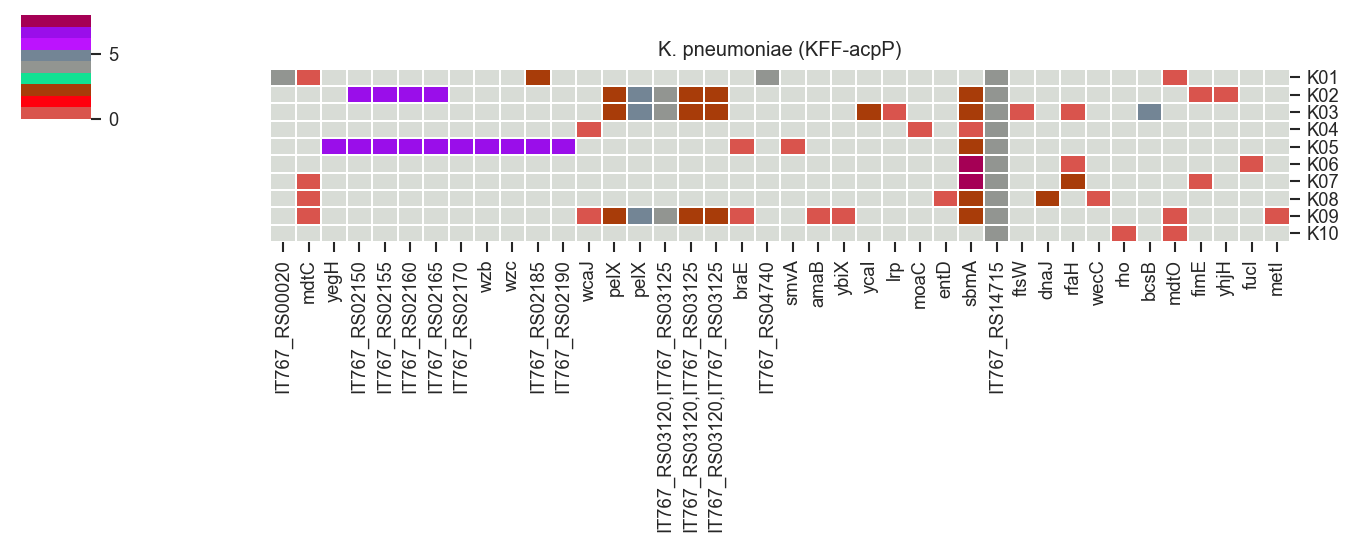

In [57]:
dset = 'K'
muts = m[m['set'] == dset]
aso, species = tags[dset]

muts = muts.sort_values(['chrom', 'locus_pos']
                       ).pivot_table(index='sample', columns=['chrom', 'locus_pos', 'og'],
                                     values='ntype', aggfunc=pick_mtype
                       ).T.reset_index().drop(columns=['chrom',
                                                       'locus_pos']).set_index('og').T
muts = muts.fillna(-1)

cm = sns.clustermap(muts,
               cmap=cmap, 
               vmin=0, vmax=8,
               row_cluster=False,
               col_cluster=False,
               figsize=(muts.shape[1] / 4.3,
                        3.85),
               linewidths=0.1,
               cbar=True);

cm.ax_heatmap.set_ylabel('')
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_title(f"{species} ({aso})")
plt.savefig(f'matrix_cm_{dset}.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

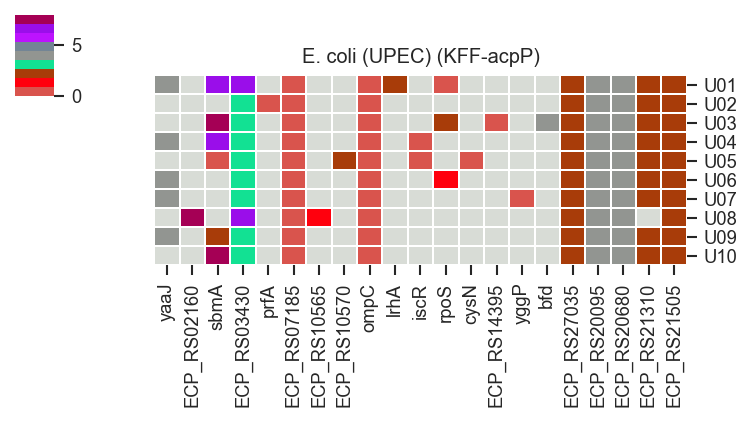

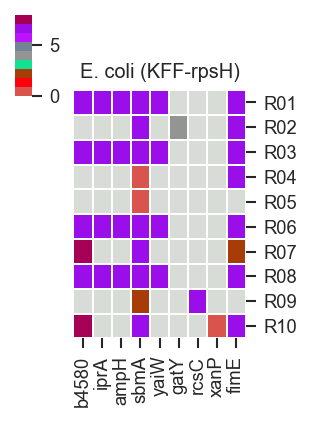

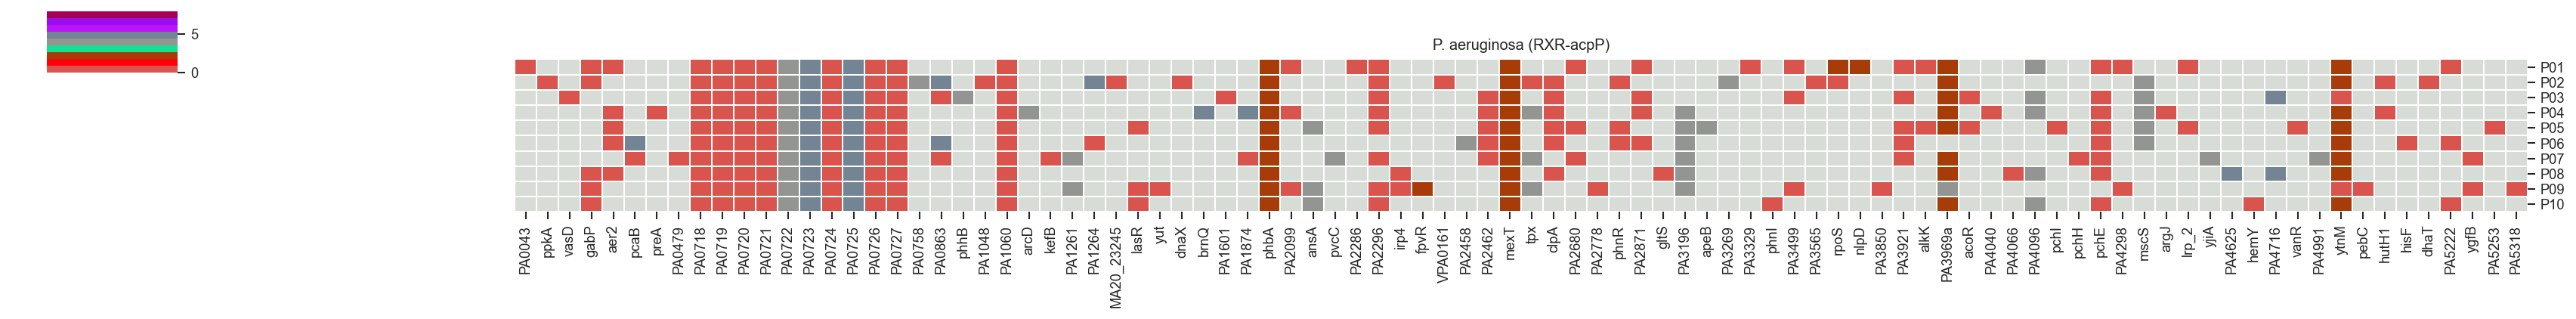

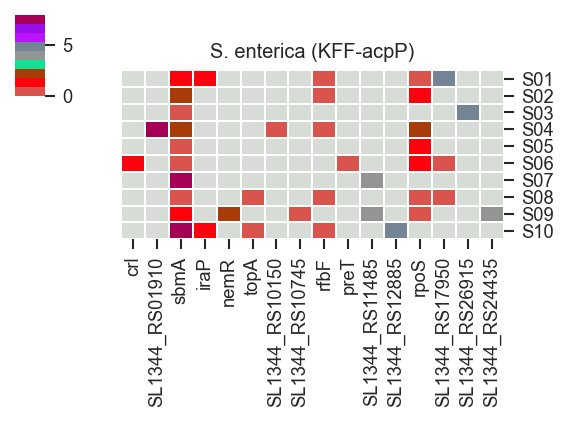

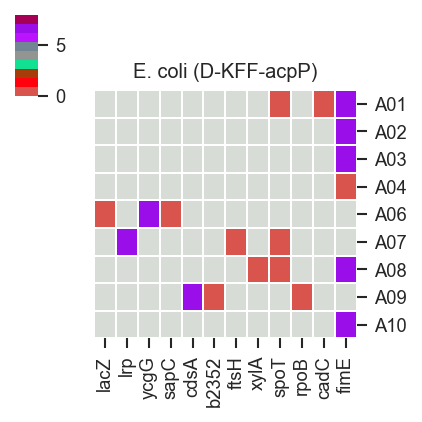

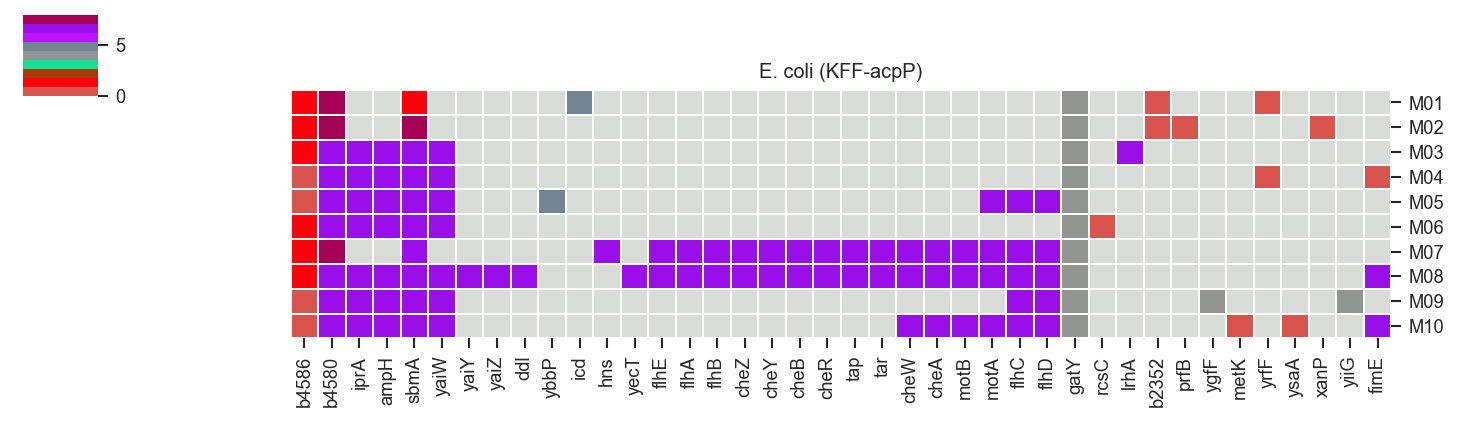

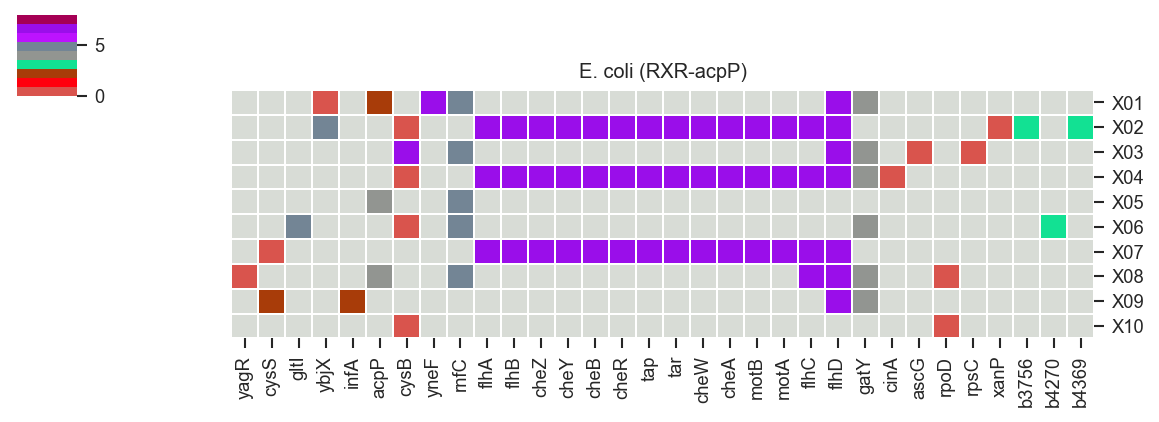

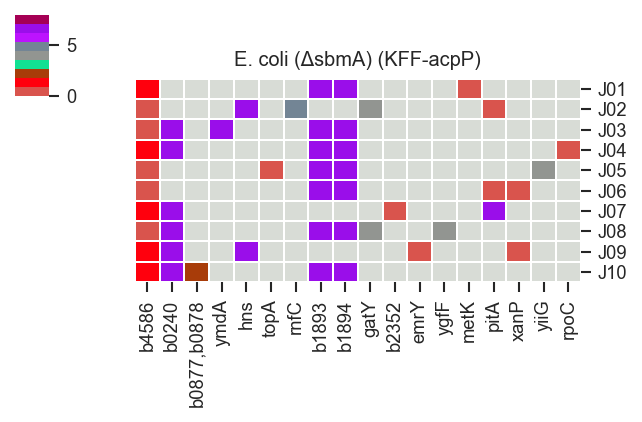

In [58]:
for dset in m['set'].unique():
    if dset == 'K':
        continue
    muts = m[m['set'] == dset]
    aso, species = tags[dset]
    
    muts = muts.sort_values(['chrom', 'locus_pos']
                           ).pivot_table(index='sample', columns=['chrom', 'locus_pos', 'og'],
                                         values='ntype', aggfunc=pick_mtype
                           ).T.reset_index().drop(columns=['chrom',
                                                           'locus_pos']).set_index('og').T
    muts = muts.fillna(-1)
    
    cm = sns.clustermap(muts,
                   cmap=cmap, 
                   vmin=0, vmax=8,
                   row_cluster=False,
                   col_cluster=False,
                   figsize=(muts.shape[1] / 4,
                            3),
                   linewidths=0.1,
                   cbar=True);
    
    cm.ax_heatmap.set_ylabel('')
    cm.ax_heatmap.set_xlabel('')
    cm.ax_heatmap.set_title(f"{species} ({aso})")
    plt.savefig(f'matrix_cm_{dset}.svg',
                dpi=300, bbox_inches='tight',
                transparent=True);

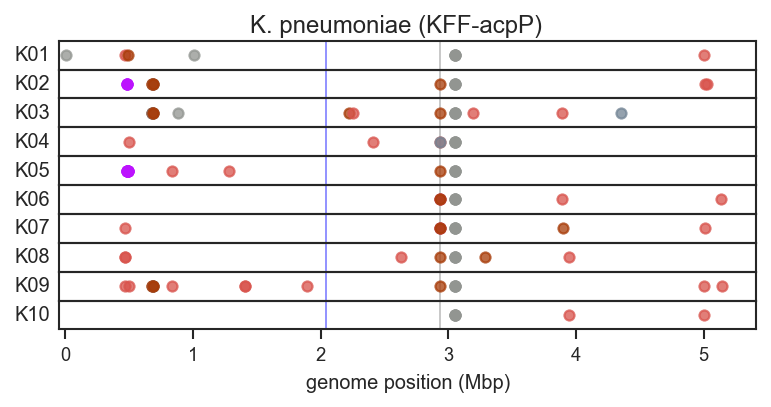

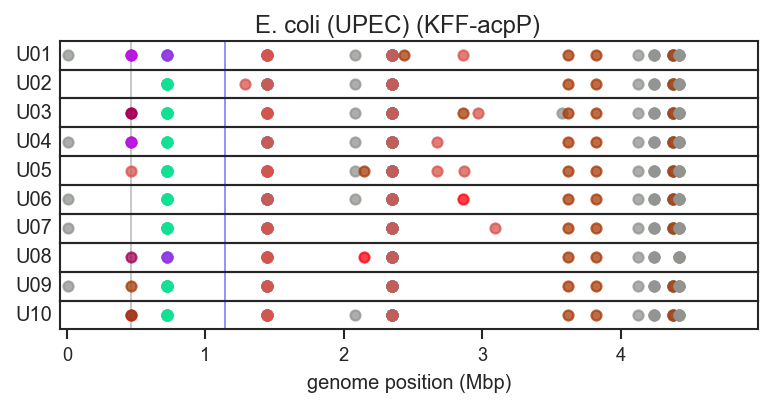

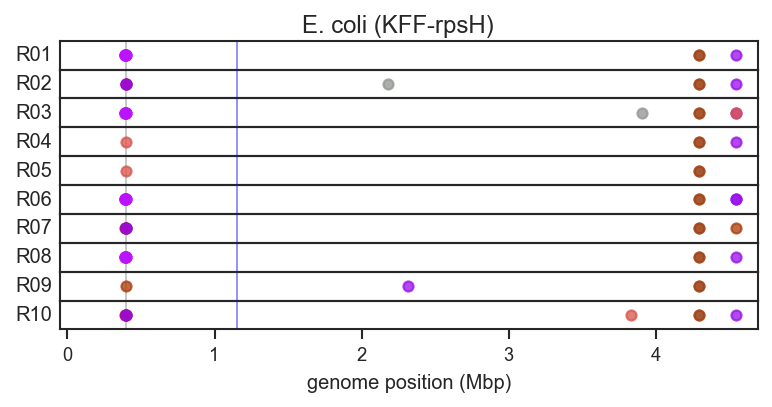

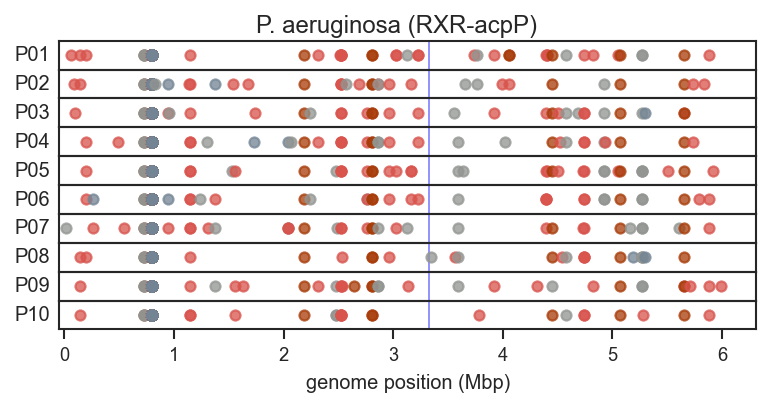

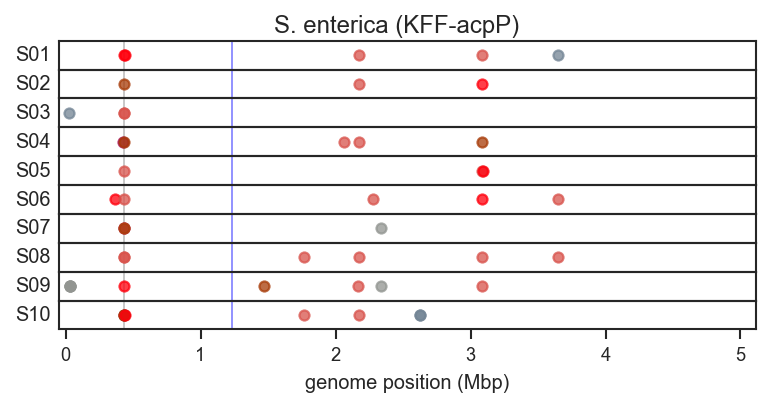

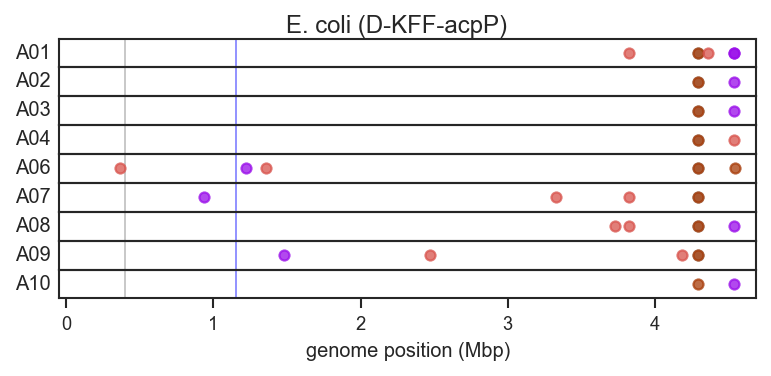

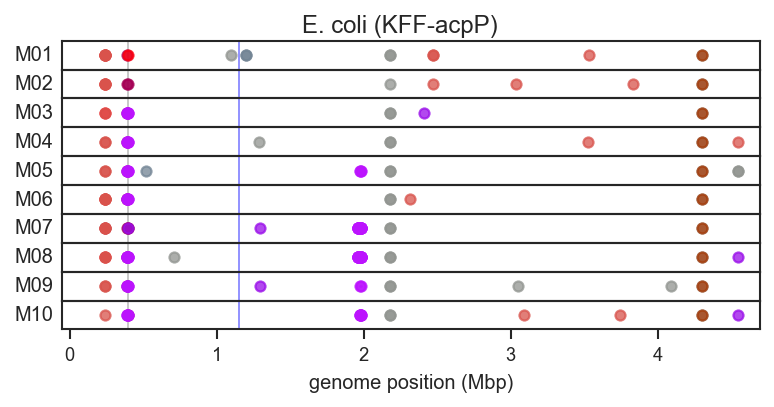

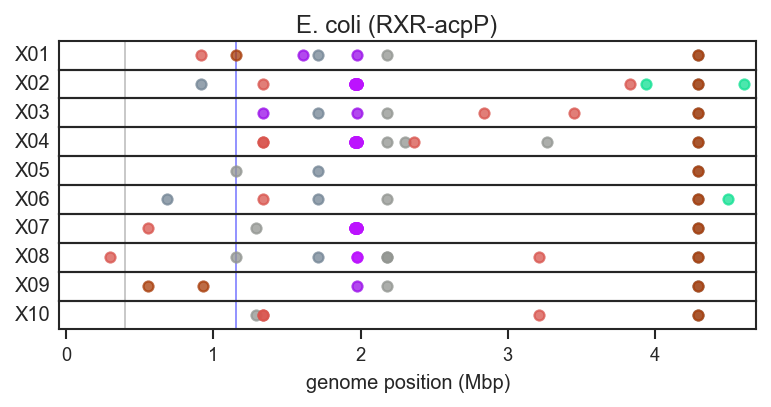

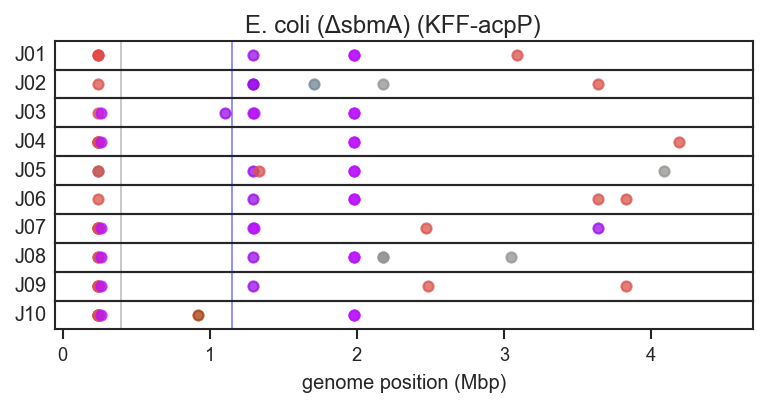

In [59]:
for dset in m['set'].unique():
    muts = m[m['set'] == dset]
    aso, species = tags[dset]
    
    fig, axes = plt.subplots(muts['sample'].unique().shape[0], 1, figsize=(6, muts['sample'].unique().shape[0] * 0.25))
    
    for i, (ax, sample) in enumerate(zip(axes.flatten(), sorted(muts['sample'].unique()))):
        for mt, ps, pe in muts[muts['sample'] == sample][['ntype', 'position_start', 'position_end']].values:
            ax.plot([int(ps) / 1_000_000, int(pe) / 1_000_000],
                     [0, 0],
                     'o-',
                     color=cmap(mt),
                     alpha=0.5)
    
        ax.set_xlim(-0.05, (glen[species] / 1_000_000) + 0.05)
        # ax.set_xlim(0.392, 0.4015)
        if species in dsbma:
            p1, p2 = dsbma[species]
            ax.fill_between([p1, p2], -1, 1,
                            color='grey', alpha=0.5)
        if dset == 'R':
            p1, p2 = drpsh[species]
            ax.fill_between([p1, p2], -1, 1,
                            color='blue', alpha=0.5)
        elif species in dacpp:
            p1, p2 = dacpp[species]
            ax.fill_between([p1, p2], -1, 1,
                            color='blue', alpha=0.5)
        ax.set_ylim(-0.01, 0.01)
        ax.set_ylabel(sample, rotation=0, ha='right', va='center')
        ax.set_yticks([])
        if i+1 != muts['sample'].unique().shape[0]:
            ax.set_xticks([])
        else:
            ax.set_xlabel('genome position (Mbp)')
    
    plt.subplots_adjust(hspace=0)
    plt.suptitle(f"{species} ({aso})", y=0.95)
    plt.savefig(f'mutations_{dset}.svg',
                dpi=300, bbox_inches='tight',
                transparent=True)
    plt.savefig(f'mutations_{dset}.png',
                dpi=300, bbox_inches='tight',
                transparent=True)

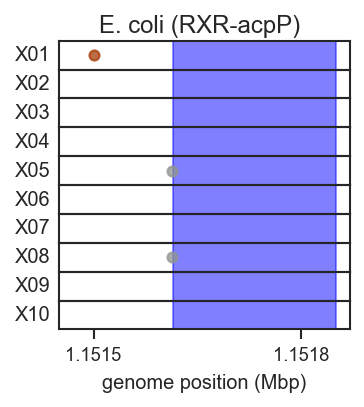

In [60]:
dset = 'X'
muts = m[m['set'] == dset]
aso, species = tags[dset]

fig, axes = plt.subplots(muts['sample'].unique().shape[0], 1, figsize=(2.5, muts['sample'].unique().shape[0] * 0.25))

for i, (ax, sample) in enumerate(zip(axes.flatten(), sorted(muts['sample'].unique()))):
    for mt, ps, pe in muts[muts['sample'] == sample][['ntype', 'position_start', 'position_end']].values:
        ax.plot([int(ps) / 1_000_000, int(pe) / 1_000_000],
                 [0, 0],
                 'o-',
                 color=cmap(mt),
                 alpha=0.5)

    ax.set_xlim(-0.05, (glen[species] / 1_000_000) + 0.05)
    ax.set_xlim(1.15145, 1.15187)
    ax.set_xticks([1.1515, 1.1518],
                  labels=[str(x) for x in [1.1515, 1.1518]])
    if species in dsbma:
        p1, p2 = dsbma[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='grey', alpha=0.5)
    if dset == 'R':
        p1, p2 = drpsh[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='blue', alpha=0.5)
    elif species in dacpp:
        p1, p2 = dacpp[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='blue', alpha=0.5)
    ax.set_ylim(-0.01, 0.01)
    ax.set_ylabel(sample, rotation=0, ha='right', va='center')
    ax.set_yticks([])
    if i+1 != muts['sample'].unique().shape[0]:
        ax.set_xticks([])
    else:
        ax.set_xlabel('genome position (Mbp)')

plt.subplots_adjust(hspace=0)
plt.suptitle(f"{species} ({aso})", y=0.95)
plt.savefig(f'mutations_zoom_{dset}.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig(f'mutations_zoom_{dset}.png',
            dpi=300, bbox_inches='tight',
            transparent=True);

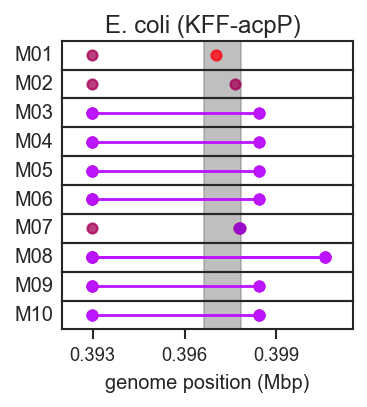

In [61]:
dset = 'M'
muts = m[m['set'] == dset]
aso, species = tags[dset]

fig, axes = plt.subplots(muts['sample'].unique().shape[0], 1, figsize=(2.5, muts['sample'].unique().shape[0] * 0.25))

for i, (ax, sample) in enumerate(zip(axes.flatten(), sorted(muts['sample'].unique()))):
    for mt, ps, pe in muts[muts['sample'] == sample][['ntype', 'position_start', 'position_end']].values:
        ax.plot([int(ps) / 1_000_000, int(pe) / 1_000_000],
                 [0, 0],
                 'o-',
                 color=cmap(mt),
                 alpha=0.5)

    ax.set_xlim(-0.05, (glen[species] / 1_000_000) + 0.05)
    ax.set_xlim(0.392, 0.4015)
    ax.set_xticks([0.393, 0.396, 0.399])
    if species in dsbma:
        p1, p2 = dsbma[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='grey', alpha=0.5)
    if dset == 'R':
        p1, p2 = drpsh[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='blue', alpha=0.5)
    elif species in dacpp:
        p1, p2 = dacpp[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='blue', alpha=0.5)
    ax.set_ylim(-0.01, 0.01)
    ax.set_ylabel(sample, rotation=0, ha='right', va='center')
    ax.set_yticks([])
    if i+1 != muts['sample'].unique().shape[0]:
        ax.set_xticks([])
    else:
        ax.set_xlabel('genome position (Mbp)')

plt.subplots_adjust(hspace=0)
plt.suptitle(f"{species} ({aso})", y=0.95)
plt.savefig(f'mutations_zoom_{dset}.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig(f'mutations_zoom_{dset}.png',
            dpi=300, bbox_inches='tight',
            transparent=True);

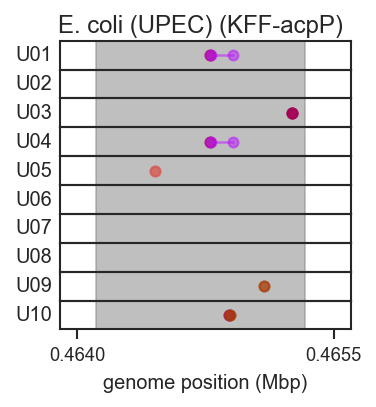

In [62]:
dset = 'U'
muts = m[m['set'] == dset]
aso, species = tags[dset]

fig, axes = plt.subplots(muts['sample'].unique().shape[0], 1, figsize=(2.5, muts['sample'].unique().shape[0] * 0.25))

for i, (ax, sample) in enumerate(zip(axes.flatten(), sorted(muts['sample'].unique()))):
    for mt, ps, pe in muts[muts['sample'] == sample][['ntype', 'position_start', 'position_end']].values:
        ax.plot([int(ps) / 1_000_000, int(pe) / 1_000_000],
                 [0, 0],
                 'o-',
                 color=cmap(mt),
                 alpha=0.5)

    ax.set_xlim(-0.05, (glen[species] / 1_000_000) + 0.05)
    ax.set_xlim(.4639, .4656)
    ax.set_xticks([0.464, 0.4655])
    if species in dsbma:
        p1, p2 = dsbma[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='grey', alpha=0.5)
    if dset == 'R':
        p1, p2 = drpsh[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='blue', alpha=0.5)
    elif species in dacpp:
        p1, p2 = dacpp[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='blue', alpha=0.5)
    ax.set_ylim(-0.01, 0.01)
    ax.set_ylabel(sample, rotation=0, ha='right', va='center')
    ax.set_yticks([])
    if i+1 != muts['sample'].unique().shape[0]:
        ax.set_xticks([])
    else:
        ax.set_xlabel('genome position (Mbp)')

plt.subplots_adjust(hspace=0)
plt.suptitle(f"{species} ({aso})", y=0.95)
plt.savefig(f'mutations_zoom_{dset}.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig(f'mutations_zoom_{dset}.png',
            dpi=300, bbox_inches='tight',
            transparent=True);

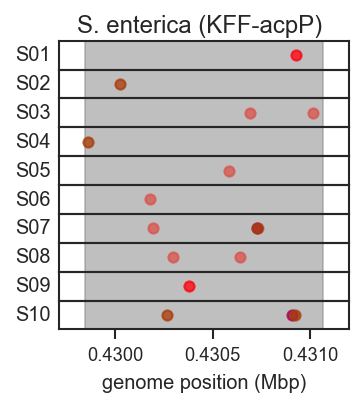

In [63]:
dset = 'S'
muts = m[m['set'] == dset]
aso, species = tags[dset]

fig, axes = plt.subplots(muts['sample'].unique().shape[0], 1, figsize=(2.5, muts['sample'].unique().shape[0] * 0.25))

for i, (ax, sample) in enumerate(zip(axes.flatten(), sorted(muts['sample'].unique()))):
    for mt, ps, pe in muts[muts['sample'] == sample][['ntype', 'position_start', 'position_end']].values:
        ax.plot([int(ps) / 1_000_000, int(pe) / 1_000_000],
                 [0, 0],
                 'o-',
                 color=cmap(mt),
                 alpha=0.5)

    ax.set_xlim(-0.05, (glen[species] / 1_000_000) + 0.05)
    ax.set_xlim(.42971, .4312)
    # ax.set_xticks([0.464, 0.4655])
    if species in dsbma:
        p1, p2 = dsbma[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='grey', alpha=0.5)
    if dset == 'R':
        p1, p2 = drpsh[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='blue', alpha=0.5)
    elif species in dacpp:
        p1, p2 = dacpp[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='blue', alpha=0.5)
    ax.set_ylim(-0.01, 0.01)
    ax.set_ylabel(sample, rotation=0, ha='right', va='center')
    ax.set_yticks([])
    if i+1 != muts['sample'].unique().shape[0]:
        ax.set_xticks([])
    else:
        ax.set_xlabel('genome position (Mbp)')

plt.subplots_adjust(hspace=0)
plt.suptitle(f"{species} ({aso})", y=0.95)
plt.savefig(f'mutations_zoom_{dset}.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig(f'mutations_zoom_{dset}.png',
            dpi=300, bbox_inches='tight',
            transparent=True);

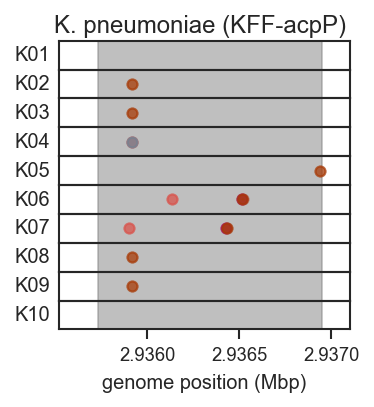

In [64]:
dset = 'K'
muts = m[m['set'] == dset]
aso, species = tags[dset]

fig, axes = plt.subplots(muts['sample'].unique().shape[0], 1, figsize=(2.5, muts['sample'].unique().shape[0] * 0.25))

for i, (ax, sample) in enumerate(zip(axes.flatten(), sorted(muts['sample'].unique()))):
    for mt, ps, pe in muts[muts['sample'] == sample][['ntype', 'position_start', 'position_end']].values:
        ax.plot([int(ps) / 1_000_000, int(pe) / 1_000_000],
                 [0, 0],
                 'o-',
                 color=cmap(mt),
                 alpha=0.5)

    ax.set_xlim(-0.05, (glen[species] / 1_000_000) + 0.05)
    ax.set_xlim(2.93552, 2.9371)
    # ax.set_xticks([0.464, 0.4655])
    if species in dsbma:
        p1, p2 = dsbma[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='grey', alpha=0.5)
    if dset == 'R':
        p1, p2 = drpsh[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='blue', alpha=0.5)
    elif species in dacpp:
        p1, p2 = dacpp[species]
        ax.fill_between([p1, p2], -1, 1,
                        color='blue', alpha=0.5)
    ax.set_ylim(-0.01, 0.01)
    ax.set_ylabel(sample, rotation=0, ha='right', va='center')
    ax.set_yticks([])
    if i+1 != muts['sample'].unique().shape[0]:
        ax.set_xticks([])
    else:
        ax.set_xlabel('genome position (Mbp)')

plt.subplots_adjust(hspace=0)
plt.suptitle(f"{species} ({aso})", y=0.95)
plt.savefig(f'mutations_zoom_{dset}.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig(f'mutations_zoom_{dset}.png',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [65]:
# vmin = sorted(fc[fc['log2(fold-change)'] > 0]['log2(fold-change)'].unique())[0]
vmin = -0
vmax = 4

In [66]:
cmap = sns.color_palette('coolwarm',
                         as_cmap=True)
cmap.set_under('xkcd:grey')
cmap.set_over('#541b26ff')

In [67]:
fc = pd.read_csv('fold_changes.tsv', sep='\t').set_index('sample')

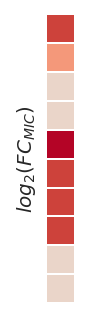

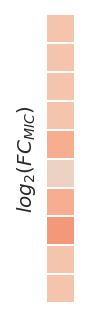

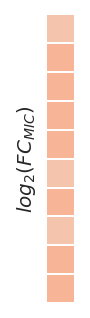

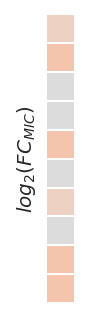

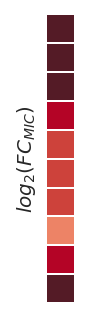

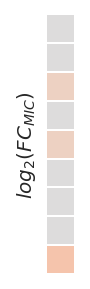

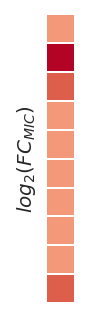

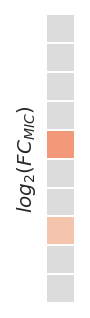

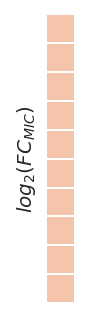

In [68]:
all_samples = m['sample'].unique()
for dset in m['set'].unique():
    idx = [x for x in fc.index
           if x.startswith(dset)
           and x in all_samples]
    plt.figure(figsize=(1.5, 0.25 * len(idx)))
    hm = sns.heatmap(fc.loc[sorted(idx),
                       ['log2(fold-change)']],
                cmap=cmap, vmin=vmin, vmax=vmax,
                center=0,
                linewidths=0.1,
                square=True,
                cbar=False)
    
    plt.xlabel('')
    plt.ylabel('$log_{2}(FC_{MIC})$')
    plt.yticks([])
    plt.xticks([])
    
    plt.savefig(f'fc_cbar_{dset}.svg',
                dpi=300, bbox_inches='tight',
                transparent=True);

/tmp/ipykernel_2798261/3017378439.py:3: UserWarning: Adding colorbar to a different Figure <Figure size 225x375 with 1 Axes> than <Figure size 300x30 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(hm.get_children()[0], orientation='horizontal', cax=plt.gca())


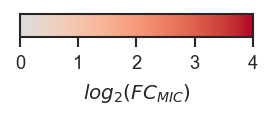

In [69]:
plt.figure(figsize=(2, .2))

plt.colorbar(hm.get_children()[0], orientation='horizontal', cax=plt.gca())

plt.xlabel('$log_{2}(FC_{MIC})$')

sns.despine(bottom=True,
            left=True,
            ax=plt.gca())

plt.savefig('fc_cbar.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('fc_cbar.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [70]:
s = SeqIO.read(gzip.open('../data/references/gbk/ecoli.gbk.gz', 'rt'),
               'genbank')
for f in s.features:
    if f.type != 'CDS':
        continue
    if f.qualifiers.get('gene', [''])[0] == 'acpP':
        break

In [71]:
seq = str(s[int(f.location.start)-10: int(f.location.start)+5].seq)

In [72]:
ref = seq

x08 = list(seq)
x08[-6] = 'C'
x08 = ''.join(x08)

x05 = list(seq)
x05[-7] = 'A'
x05 = ''.join(x05)

In [73]:
base2int = {'A': 0,
            'G': 1,
            'T': 2,
            'C': 3}

In [74]:
acpP = pd.DataFrame([list(ref),
                     list(ref),
                     list(ref),
                     list(ref),
                     list(ref),
                     list(x05),
                     list(ref),
                     list(ref),
                     list(x08),
                     list(ref),
                     list(ref),],
                    index=['WT',] + [f'X{x:02d}' for x in range(1, 11)],
                    columns=range(-10, 5))
acpP = acpP.stack().reset_index()
acpP.columns = ['sample', 'position', 'base']
acpP['scalar'] = [base2int[x] for x in acpP['base'].values]

In [75]:
base_colors = list(sns.color_palette('tab20', 4))
cmap = LinearSegmentedColormap.from_list('nucleotides', base_colors, 4)
cmap.set_bad('xkcd:grey')
cmap.set_over(list(sns.color_palette('tab20', 5))[-1])

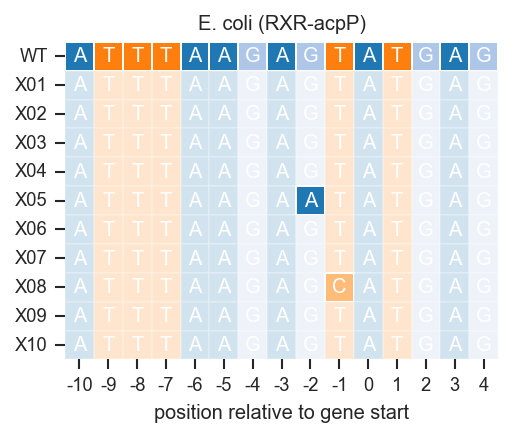

In [76]:
plt.figure(figsize=(4, 0.25 * 11))

t = acpP.pivot_table(index='sample',
                     columns='position',
                     values='base',
                     aggfunc=lambda x: x)
a = np.zeros(t.shape) + 0.2
a[0] = np.ones(t.shape[1])
a[5] = np.zeros(t.shape[1]) + 0.2
a[5, -7] = 1
a[8] = np.zeros(t.shape[1]) + 0.2
a[8, -6] = 1

sns.heatmap(acpP.pivot_table(index='sample',
                             columns='position',
                             values='scalar'),
            cmap=cmap,
            cbar=False,
            linewidths=0.1,
            square=True,
            alpha=a)


for x in range(t.shape[1]):
    for y in range(t.shape[0]):
        plt.text(x+0.5, y+0.5, t.iloc[y, x],
                ha='center', va='center',
                color='w')

plt.ylabel('')
plt.xlabel('position relative to gene start')
aso, species = tags['X']
plt.title(f"{species} ({aso})")

plt.savefig('acpP.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('acpP.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);